In [8]:
import Infernal
import Rfam
import FASTX
import Makie
import CairoMakie
using RestrictedBoltzmannMachines: RBM, xReLU, log_pseudolikelihood, initialize!, pcd!, 
    sample_from_inputs, sample_v_from_v, free_energy
using StandardizedRestrictedBoltzmannMachines: standardize
using PottsGumbelRBMLayers: PottsGumbel
using CudaRBMs: gpu, cpu
using BioSequences: LongRNA, @rna_str
using Statistics: mean, cov
using Random: bitrand
using LinearAlgebra: norm
using Optimisers: Adam
using ProgressMeter: @showprogress
using Logomaker: Logo
using LogExpFunctions: xlogx
using MiniLoggers: global_logger, MiniLogger
global_logger(MiniLogger());

In [9]:
Rfam.set_rfam_directory("/data/cossio/data/Rfam") # set to a local directory where RFAM data will be downloaded
Rfam.set_rfam_version("14.10")

[2024-01-09 15:06:13] Info: RFAM Directory /data/cossio/data/Rfam set.


[2024-01-09 15:06:13] Info: Rfam version 14.10 set.


In [10]:
# trimmed (no inserts) aligned fasta
RF00162_hits_afa = Infernal.cmalign(Infernal.cmfetch(Rfam.cm(), "RF00162").out, Rfam.fasta_file("RF00162"); matchonly=true, outformat="AFA");
# these are already aligned and without inserts
RF00162_hits_sequences = FASTX.sequence.(FASTX.FASTA.Reader(open(RF00162_hits_afa.out)));
@assert only(unique(length.(RF00162_hits_sequences))) == 108
RF00162_hits_sequences = LongRNA{4}.(RF00162_hits_sequences);

# Onehot encoding

In [11]:
function onehot(seq::LongRNA{4})
    seq_ = collect(seq)
    return reshape(seq_, 1, size(seq_)...) .== collect(rna"ACGU-")
end

function onehot(seqs::AbstractVector{<:LongRNA})
    L = only(unique(length.(seqs)))
    return reshape(reduce(hcat, onehot.(seqs)), 5, L, length(seqs))
end

onehot (generic function with 2 methods)

In [12]:
data_hits = onehot(RF00162_hits_sequences)

5×108×6161 BitArray{3}:
[:, :, 1] =
 0  0  0  0  0  1  0  0  1  1  0  1  0  …  1  1  1  1  0  1  0  1  1  0  1  1
 1  0  1  0  0  0  0  1  0  0  0  0  0     0  0  0  0  0  0  0  0  0  0  0  0
 0  0  0  0  0  0  0  0  0  0  1  0  1     0  0  0  0  1  0  0  0  0  1  0  0
 0  1  0  1  1  0  1  0  0  0  0  0  0     0  0  0  0  0  0  1  0  0  0  0  0
 0  0  0  0  0  0  0  0  0  0  0  0  0     0  0  0  0  0  0  0  0  0  0  0  0

[:, :, 2] =
 0  0  0  0  0  1  0  0  0  1  0  1  0  …  0  1  0  1  0  1  0  0  1  0  1  0
 1  0  1  0  0  0  0  1  0  0  0  0  0     0  0  0  0  0  0  0  0  0  0  0  0
 0  0  0  0  0  0  0  0  0  0  1  0  1     1  0  1  0  1  0  0  1  0  1  0  1
 0  1  0  1  1  0  1  0  1  0  0  0  0     0  0  0  0  0  0  1  0  0  0  0  0
 0  0  0  0  0  0  0  0  0  0  0  0  0     0  0  0  0  0  0  0  0  0  0  0  0

[:, :, 3] =
 0  0  0  0  0  1  0  0  1  1  0  1  0  …  0  1  0  1  0  1  0  1  1  0  1  1
 0  0  1  0  0  0  0  1  0  0  0  0  0     0  0  0  0  0  0  0  0  0  0  0  0
 0

# Plot a sequence logo

In [13]:
xlog2x(x) = xlogx(x) / log(oftype(x,2))

function seqlogo_entropic(p::AbstractMatrix; max_ylim=true)
    @assert size(p, 1) == 5 # nucleotides + gap
    w = p ./ sum(p; dims=1)
    H = sum(-xlog2x.(w); dims=1)
    @assert all(0 .≤ H .≤ log2(5))

    cons = w .* (log2(5) .- H)
    logo = Logo(cons, collect("ACGU⊟"); color_scheme="classic")
    max_ylim && logo.ax.set_ylim(0, log2(5))
    logo.ax.set_ylabel("conservation (bits)")
    logo.ax.set_xlabel("site")

    return logo
end

function seqlogo_fields(w::AbstractMatrix)
    logo = Logo(w, collect("ACGU⊟"); color_scheme="classic")
    logo.ax.set_ylabel("fields")
    logo.ax.set_xlabel("site")
    return logo
end

seqlogo_fields (generic function with 1 method)

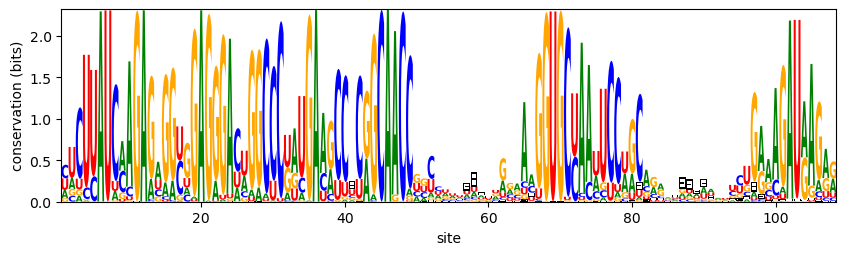

In [14]:
seqlogo_entropic(reshape(mean(data_hits; dims=3), 5, 108)).fig

# Train RBM

In [15]:
function callback(; rbm, optim, state, ps, iter, vm, vd, ∂)
    if iszero(iter % 500)
        Δt = @elapsed (lpl = mean(log_pseudolikelihood(cpu(rbm), cpu(data_hits))))
        @info iter lpl Δt
    end
end

callback (generic function with 1 method)

In [16]:
rbm = RBM(PottsGumbel((5, 108)), xReLU((100,)), zeros(5, 108, 100))
initialize!(rbm, data_hits);
rbm = gpu(standardize(rbm));

In [17]:
training_time = @elapsed begin
    state, ps = pcd!(
        rbm, gpu(data_hits);
        optim=Adam(1f-4, (0f0, 999f-3), 1f-6), steps=50, batchsize=256, iters=50000, 
        vm = gpu(bitrand(size(rbm.visible)..., 256)), l2l1_weights=0.1,
        ϵv=1f-1, ϵh=0f0, damping=1f-1, # parameters controlling the hidden unit statistics normalization
        callback
    )
end

[2024-01-09 15:08:41] Info: 500 lpl = -0.5908897737301934, Δt = 7.816201086


[2024-01-09 15:08:55] Info: 1000 lpl = -0.5565456565089658, Δt = 0.876278226


[2024-01-09 15:09:08] Info: 1500 lpl = -0.5267624630803902, Δt = 0.688590988


[2024-01-09 15:09:21] Info: 2000 lpl = -0.5035114779827143, Δt = 0.827014066


[2024-01-09 15:09:35] Info: 2500 lpl = -0.4766206618527707, Δt = 0.713066679


[2024-01-09 15:09:48] Info: 3000 lpl = -0.47264341490583306, Δt = 0.861799662


[2024-01-09 15:10:02] Info: 3500 lpl = -0.46972968558875283, Δt = 0.724654436


[2024-01-09 15:10:15] Info: 4000 lpl = -0.4766923070500115, Δt = 0.814352449


[2024-01-09 15:10:28] Info: 4500 lpl = -0.4226757976885842, Δt = 0.712050543


[2024-01-09 15:10:42] Info: 5000 lpl = -0.45693832983093446, Δt = 0.849289706


[2024-01-09 15:10:55] Info: 5500 lpl = -0.4274580641215542, Δt = 0.732558024


[2024-01-09 15:11:08] Info: 6000 lpl = -0.4250003692085936, Δt = 0.771963149


[2024-01-09 15:11:22] Info: 6500 lpl = -0.4195199791147494, Δt = 0.684164025


[2024-01-09 15:11:35] Info: 7000 lpl = -0.4009136469904702, Δt = 0.784138357


[2024-01-09 15:11:49] Info: 7500 lpl = -0.4149451690702381, Δt = 0.896287321


[2024-01-09 15:12:02] Info: 8000 lpl = -0.4125054340412869, Δt = 0.726704862


[2024-01-09 15:12:16] Info: 8500 lpl = -0.4142420110784502, Δt = 0.895030559


[2024-01-09 15:12:29] Info: 9000 lpl = -0.41517333128855705, Δt = 0.737508912


[2024-01-09 15:12:42] Info: 9500 lpl = -0.39695058480821405, Δt = 0.841105875


[2024-01-09 15:12:56] Info: 10000 lpl = -0.3921003718511394, Δt = 0.721083772


[2024-01-09 15:13:09] Info: 10500 lpl = -0.3800167310317268, Δt = 0.834986924


[2024-01-09 15:13:23] Info: 11000 lpl = -0.39811473924847707, Δt = 0.735208654


[2024-01-09 15:13:36] Info: 11500 lpl = -0.3921172961982738, Δt = 0.791305546


[2024-01-09 15:13:50] Info: 12000 lpl = -0.3734926656893092, Δt = 0.70986395


[2024-01-09 15:14:03] Info: 12500 lpl = -0.3838249557695109, Δt = 0.781097622


[2024-01-09 15:14:17] Info: 13000 lpl = -0.3933994310270584, Δt = 0.905079055


[2024-01-09 15:14:30] Info: 13500 lpl = -0.3848370959114741, Δt = 0.747917331


[2024-01-09 15:14:44] Info: 14000 lpl = -0.38191388762516043, Δt = 0.885175075


[2024-01-09 15:14:57] Info: 14500 lpl = -0.37297014742922735, Δt = 0.721138963


[2024-01-09 15:15:11] Info: 15000 lpl = -0.3767729677012133, Δt = 0.841795794


[2024-01-09 15:15:24] Info: 15500 lpl = -0.39192458424899296, Δt = 0.75577393


[2024-01-09 15:15:38] Info: 16000 lpl = -0.386308163854842, Δt = 0.828078034


[2024-01-09 15:15:51] Info: 16500 lpl = -0.3617747622384832, Δt = 0.734313224


[2024-01-09 15:16:05] Info: 17000 lpl = -0.39652929485652466, Δt = 0.77188964


[2024-01-09 15:16:18] Info: 17500 lpl = -0.3839045836155491, Δt = 0.721094705


[2024-01-09 15:16:32] Info: 18000 lpl = -0.3658674982828349, Δt = 0.778844252


[2024-01-09 15:16:46] Info: 18500 lpl = -0.371586284158414, Δt = 0.906322735


[2024-01-09 15:16:59] Info: 19000 lpl = -0.37686578148950095, Δt = 0.741847483


[2024-01-09 15:17:13] Info: 19500 lpl = -0.3670451528953112, Δt = 0.913899646


[2024-01-09 15:17:26] Info: 20000 lpl = -0.37307829374958906, Δt = 0.700987698


[2024-01-09 15:17:40] Info: 20500 lpl = -0.3722705294883822, Δt = 0.840188227


[2024-01-09 15:17:53] Info: 21000 lpl = -0.35429911510508333, Δt = 0.726002831


[2024-01-09 15:18:07] Info: 21500 lpl = -0.364767838867944, Δt = 0.865995378


[2024-01-09 15:18:20] Info: 22000 lpl = -0.36157076797169174, Δt = 0.736763991


[2024-01-09 15:18:34] Info: 22500 lpl = -0.3654870479407879, Δt = 0.795312292


[2024-01-09 15:18:47] Info: 23000 lpl = -0.38430535507486957, Δt = 0.700891327


[2024-01-09 15:19:01] Info: 23500 lpl = -0.36809232896503724, Δt = 0.816463534


[2024-01-09 15:19:15] Info: 24000 lpl = -0.36994660672360985, Δt = 0.913134728


[2024-01-09 15:19:28] Info: 24500 lpl = -0.36063978698507015, Δt = 0.744632655


[2024-01-09 15:19:42] Info: 25000 lpl = -0.36847382662872796, Δt = 0.885697931


[2024-01-09 15:19:55] Info: 25500 lpl = -0.35879950757923645, Δt = 0.738221997


[2024-01-09 15:20:09] Info: 26000 lpl = -0.3519599565815772, Δt = 0.844492042


[2024-01-09 15:20:22] Info: 26500 lpl = -0.3669516392571803, Δt = 0.726032024


[2024-01-09 15:20:36] Info: 27000 lpl = -0.3638234501145019, Δt = 0.833436739


[2024-01-09 15:20:50] Info: 27500 lpl = -0.35357845042625297, Δt = 0.752534846


[2024-01-09 15:21:03] Info: 28000 lpl = -0.37441416971426994, Δt = 0.771587083


[2024-01-09 15:21:17] Info: 28500 lpl = -0.36635416312192204, Δt = 0.695039386


[2024-01-09 15:21:30] Info: 29000 lpl = -0.3649745542143156, Δt = 0.774433314


[2024-01-09 15:21:44] Info: 29500 lpl = -0.37117987684529197, Δt = 0.958511978


[2024-01-09 15:21:58] Info: 30000 lpl = -0.3637836490456289, Δt = 0.739373158


[2024-01-09 15:22:11] Info: 30500 lpl = -0.37492582136391456, Δt = 0.896536274


[2024-01-09 15:22:25] Info: 31000 lpl = -0.3451160137992005, Δt = 0.722069107


[2024-01-09 15:22:39] Info: 31500 lpl = -0.35614655050512267, Δt = 0.863751158


[2024-01-09 15:22:52] Info: 32000 lpl = -0.37867617919691665, Δt = 0.721166495


[2024-01-09 15:23:06] Info: 32500 lpl = -0.3529742440789788, Δt = 0.848491137


[2024-01-09 15:23:20] Info: 33000 lpl = -0.3746289558497406, Δt = 0.735618411


[2024-01-09 15:23:33] Info: 33500 lpl = -0.3361484908081091, Δt = 0.793382941


[2024-01-09 15:23:47] Info: 34000 lpl = -0.36094459476150526, Δt = 0.695807345


[2024-01-09 15:24:01] Info: 34500 lpl = -0.34932220980493733, Δt = 0.775057098


[2024-01-09 15:24:14] Info: 35000 lpl = -0.34678227822336416, Δt = 0.929093803


[2024-01-09 15:24:28] Info: 35500 lpl = -0.36495545838818355, Δt = 0.756963253


[2024-01-09 15:24:42] Info: 36000 lpl = -0.3615718163889486, Δt = 0.901506058


[2024-01-09 15:24:56] Info: 36500 lpl = -0.3657966178791539, Δt = 0.707774419


[2024-01-09 15:25:09] Info: 37000 lpl = -0.3443548042373239, Δt = 0.838127408


[2024-01-09 15:25:23] Info: 37500 lpl = -0.3648711784003392, Δt = 0.768905965


[2024-01-09 15:25:37] Info: 38000 lpl = -0.3520514756333146, Δt = 0.843601671


[2024-01-09 15:25:50] Info: 38500 lpl = -0.34780825281016065, Δt = 0.741403225


[2024-01-09 15:26:04] Info: 39000 lpl = -0.35487015066234273, Δt = 0.773881327


[2024-01-09 15:26:18] Info: 39500 lpl = -0.35768715076272295, Δt = 0.733311672


[2024-01-09 15:26:31] Info: 40000 lpl = -0.3573938904368148, Δt = 0.757908876


[2024-01-09 15:26:45] Info: 40500 lpl = -0.3645600391758432, Δt = 1.131720036


[2024-01-09 15:27:00] Info: 41000 lpl = -0.36147465895393494, Δt = 0.944914334


[2024-01-09 15:27:14] Info: 41500 lpl = -0.3452920830999749, Δt = 1.115696062


[2024-01-09 15:27:28] Info: 42000 lpl = -0.34785860692765924, Δt = 0.740022755


[2024-01-09 15:27:42] Info: 42500 lpl = -0.3392717894159526, Δt = 0.940611917


[2024-01-09 15:27:57] Info: 43000 lpl = -0.3617992275597806, Δt = 1.10154022


[2024-01-09 15:28:12] Info: 43500 lpl = -0.35499302937072275, Δt = 0.914516205


[2024-01-09 15:28:26] Info: 44000 lpl = -0.35169675255605887, Δt = 0.774448087


[2024-01-09 15:28:40] Info: 44500 lpl = -0.36095319692162847, Δt = 0.805625706


[2024-01-09 15:28:54] Info: 45000 lpl = -0.34785385842044203, Δt = 0.750719741


[2024-01-09 15:29:08] Info: 45500 lpl = -0.3602325871877761, Δt = 0.837538487


[2024-01-09 15:29:23] Info: 46000 lpl = -0.35720938014244086, Δt = 0.986223019


[2024-01-09 15:29:37] Info: 46500 lpl = -0.3393088605469469, Δt = 0.817476235


[2024-01-09 15:29:51] Info: 47000 lpl = -0.3468542231893127, Δt = 0.98393646


[2024-01-09 15:30:05] Info: 47500 lpl = -0.3375706149033166, Δt = 0.777506603


[2024-01-09 15:30:19] Info: 48000 lpl = -0.3501592151988602, Δt = 0.879397963


[2024-01-09 15:30:33] Info: 48500 lpl = -0.3675246583392605, Δt = 0.733519766


[2024-01-09 15:30:47] Info: 49000 lpl = -0.35457965381848333, Δt = 0.832713092


[2024-01-09 15:31:01] Info: 49500 lpl = -0.359987529719587, Δt = 0.738246694


[2024-01-09 15:31:15] Info: 50000 lpl = -0.3519810735322679, Δt = 0.79044627


1439.677100485

# Check convergence

In [18]:
sampled_v = sample_from_inputs(gpu(rbm).visible, gpu(zeros(size(rbm.visible)..., 2000)));
sampled_f = zeros(5000)
@showprogress for t in 1:length(sampled_f)
    sampled_v .= sample_v_from_v(rbm, sampled_v; steps=50)
    sampled_f[t] = mean(free_energy(rbm, sampled_v))
end

Progress:   0%|                                         |  ETA: 3:08:31

Progress:   0%|▏                                        |  ETA: 0:22:01

Progress:   1%|▎                                        |  ETA: 0:14:48

Progress:   1%|▍                                        |  ETA: 0:13:31

Progress:   1%|▍                                        |  ETA: 0:12:33

Progress:   1%|▍                                        |  ETA: 0:11:40

Progress:   1%|▍                                        |  ETA: 0:10:56

Progress:   1%|▌                                        |  ETA: 0:10:22

Progress:   1%|▌                                        |  ETA: 0:09:49

Progress:   1%|▌                                        |  ETA: 0:09:20

Progress:   1%|▌                                        |  ETA: 0:08:58

Progress:   1%|▋                                        |  ETA: 0:08:35

Progress:   2%|▋                                        |  ETA: 0:08:14

Progress:   2%|▋                                        |  ETA: 0:07:59

Progress:   2%|▋                                        |  ETA: 0:07:42

Progress:   2%|▊                                        |  ETA: 0:07:27

Progress:   2%|▊                                        |  ETA: 0:07:15

Progress:   2%|▊                                        |  ETA: 0:07:02

Progress:   2%|▊                                        |  ETA: 0:06:50

Progress:   2%|▉                                        |  ETA: 0:06:43

Progress:   2%|▉                                        |  ETA: 0:06:33

Progress:   2%|▉                                        |  ETA: 0:06:23

Progress:   2%|█                                        |  ETA: 0:06:14

Progress:   2%|█                                        |  ETA: 0:06:08

Progress:   2%|█                                        |  ETA: 0:06:00

Progress:   3%|█                                        |  ETA: 0:05:53

Progress:   3%|█▏                                       |  ETA: 0:05:48

Progress:   3%|█▏                                       |  ETA: 0:05:41

Progress:   3%|█▏                                       |  ETA: 0:05:35

Progress:   3%|█▏                                       |  ETA: 0:05:31

Progress:   3%|█▎                                       |  ETA: 0:05:25

Progress:   3%|█▎                                       |  ETA: 0:05:20

Progress:   3%|█▎                                       |  ETA: 0:05:16

Progress:   3%|█▎                                       |  ETA: 0:05:12

Progress:   3%|█▍                                       |  ETA: 0:05:07

Progress:   3%|█▍                                       |  ETA: 0:05:04

Progress:   3%|█▍                                       |  ETA: 0:05:00

Progress:   4%|█▍                                       |  ETA: 0:04:56

Progress:   4%|█▌                                       |  ETA: 0:04:53

Progress:   4%|█▌                                       |  ETA: 0:04:50

Progress:   4%|█▌                                       |  ETA: 0:04:46

Progress:   4%|█▋                                       |  ETA: 0:04:43

Progress:   4%|█▋                                       |  ETA: 0:04:41

Progress:   4%|█▋                                       |  ETA: 0:04:37

Progress:   4%|█▋                                       |  ETA: 0:04:34

Progress:   4%|█▊                                       |  ETA: 0:04:33

Progress:   4%|█▊                                       |  ETA: 0:04:30

Progress:   4%|█▊                                       |  ETA: 0:04:27

Progress:   4%|█▊                                       |  ETA: 0:04:25

Progress:   4%|█▉                                       |  ETA: 0:04:23

Progress:   5%|█▉                                       |  ETA: 0:04:20

Progress:   5%|█▉                                       |  ETA: 0:04:19

Progress:   5%|█▉                                       |  ETA: 0:04:17

Progress:   5%|██                                       |  ETA: 0:04:14

Progress:   5%|██                                       |  ETA: 0:04:13

Progress:   5%|██                                       |  ETA: 0:04:11

Progress:   5%|██                                       |  ETA: 0:04:09

Progress:   5%|██▏                                      |  ETA: 0:04:08

Progress:   5%|██▏                                      |  ETA: 0:04:06

Progress:   5%|██▏                                      |  ETA: 0:04:04

Progress:   5%|██▎                                      |  ETA: 0:04:02

Progress:   5%|██▎                                      |  ETA: 0:04:01

Progress:   6%|██▎                                      |  ETA: 0:03:59

Progress:   6%|██▎                                      |  ETA: 0:03:58

Progress:   6%|██▍                                      |  ETA: 0:03:57

Progress:   6%|██▍                                      |  ETA: 0:03:55

Progress:   6%|██▍                                      |  ETA: 0:03:53

Progress:   6%|██▍                                      |  ETA: 0:03:53

Progress:   6%|██▌                                      |  ETA: 0:03:51

Progress:   6%|██▌                                      |  ETA: 0:03:50

Progress:   6%|██▌                                      |  ETA: 0:03:49

Progress:   6%|██▌                                      |  ETA: 0:03:47

Progress:   6%|██▋                                      |  ETA: 0:03:46

Progress:   6%|██▋                                      |  ETA: 0:03:46

Progress:   6%|██▋                                      |  ETA: 0:03:44

Progress:   7%|██▋                                      |  ETA: 0:03:43

Progress:   7%|██▊                                      |  ETA: 0:03:43

Progress:   7%|██▊                                      |  ETA: 0:03:41

Progress:   7%|██▊                                      |  ETA: 0:03:40

Progress:   7%|██▉                                      |  ETA: 0:03:39

Progress:   7%|██▉                                      |  ETA: 0:03:38

Progress:   7%|██▉                                      |  ETA: 0:03:37

Progress:   7%|██▉                                      |  ETA: 0:03:36

Progress:   7%|███                                      |  ETA: 0:03:36

Progress:   7%|███                                      |  ETA: 0:03:35

Progress:   7%|███                                      |  ETA: 0:03:33

Progress:   7%|███                                      |  ETA: 0:03:33

Progress:   8%|███▏                                     |  ETA: 0:03:32

Progress:   8%|███▏                                     |  ETA: 0:03:31

Progress:   8%|███▏                                     |  ETA: 0:03:31

Progress:   8%|███▏                                     |  ETA: 0:03:29

Progress:   8%|███▎                                     |  ETA: 0:03:29

Progress:   8%|███▎                                     |  ETA: 0:03:28

Progress:   8%|███▎                                     |  ETA: 0:03:27

Progress:   8%|███▎                                     |  ETA: 0:03:26

Progress:   8%|███▍                                     |  ETA: 0:03:26

Progress:   8%|███▍                                     |  ETA: 0:03:25

Progress:   8%|███▍                                     |  ETA: 0:03:24

Progress:   8%|███▍                                     |  ETA: 0:03:23

Progress:   8%|███▌                                     |  ETA: 0:03:23

Progress:   9%|███▌                                     |  ETA: 0:03:22

Progress:   9%|███▌                                     |  ETA: 0:03:21

Progress:   9%|███▋                                     |  ETA: 0:03:21

Progress:   9%|███▋                                     |  ETA: 0:03:20

Progress:   9%|███▋                                     |  ETA: 0:03:19

Progress:   9%|███▋                                     |  ETA: 0:03:19

Progress:   9%|███▊                                     |  ETA: 0:03:18

Progress:   9%|███▊                                     |  ETA: 0:03:17

Progress:   9%|███▊                                     |  ETA: 0:03:17

Progress:   9%|███▊                                     |  ETA: 0:03:16

Progress:   9%|███▉                                     |  ETA: 0:03:16

Progress:   9%|███▉                                     |  ETA: 0:03:15

Progress:  10%|███▉                                     |  ETA: 0:03:14

Progress:  10%|███▉                                     |  ETA: 0:03:14

Progress:  10%|████                                     |  ETA: 0:03:14

Progress:  10%|████                                     |  ETA: 0:03:13

Progress:  10%|████                                     |  ETA: 0:03:12

Progress:  10%|████                                     |  ETA: 0:03:11

Progress:  10%|████▏                                    |  ETA: 0:03:11

Progress:  10%|████▏                                    |  ETA: 0:03:10

Progress:  10%|████▏                                    |  ETA: 0:03:10

Progress:  10%|████▎                                    |  ETA: 0:03:10

Progress:  10%|████▎                                    |  ETA: 0:03:09

Progress:  10%|████▎                                    |  ETA: 0:03:08

Progress:  10%|████▎                                    |  ETA: 0:03:08

Progress:  11%|████▍                                    |  ETA: 0:03:07

Progress:  11%|████▍                                    |  ETA: 0:03:07

Progress:  11%|████▍                                    |  ETA: 0:03:07

Progress:  11%|████▍                                    |  ETA: 0:03:06

Progress:  11%|████▌                                    |  ETA: 0:03:05

Progress:  11%|████▌                                    |  ETA: 0:03:05

Progress:  11%|████▌                                    |  ETA: 0:03:05

Progress:  11%|████▌                                    |  ETA: 0:03:04

Progress:  11%|████▋                                    |  ETA: 0:03:04

Progress:  11%|████▋                                    |  ETA: 0:03:03

Progress:  11%|████▋                                    |  ETA: 0:03:03

Progress:  11%|████▋                                    |  ETA: 0:03:02

Progress:  12%|████▊                                    |  ETA: 0:03:02

Progress:  12%|████▊                                    |  ETA: 0:03:01

Progress:  12%|████▊                                    |  ETA: 0:03:01

Progress:  12%|████▉                                    |  ETA: 0:03:01

Progress:  12%|████▉                                    |  ETA: 0:03:00

Progress:  12%|████▉                                    |  ETA: 0:03:00

Progress:  12%|████▉                                    |  ETA: 0:02:59

Progress:  12%|█████                                    |  ETA: 0:02:59

Progress:  12%|█████                                    |  ETA: 0:02:58

Progress:  12%|█████                                    |  ETA: 0:02:58

Progress:  12%|█████                                    |  ETA: 0:02:58

Progress:  12%|█████▏                                   |  ETA: 0:02:57

Progress:  12%|█████▏                                   |  ETA: 0:02:57

Progress:  13%|█████▏                                   |  ETA: 0:02:56

Progress:  13%|█████▏                                   |  ETA: 0:02:56

Progress:  13%|█████▎                                   |  ETA: 0:02:56

Progress:  13%|█████▎                                   |  ETA: 0:02:55

Progress:  13%|█████▎                                   |  ETA: 0:02:55

Progress:  13%|█████▎                                   |  ETA: 0:02:54

Progress:  13%|█████▍                                   |  ETA: 0:02:54

Progress:  13%|█████▍                                   |  ETA: 0:02:54

Progress:  13%|█████▍                                   |  ETA: 0:02:53

Progress:  13%|█████▍                                   |  ETA: 0:02:53

Progress:  13%|█████▌                                   |  ETA: 0:02:53

Progress:  13%|█████▌                                   |  ETA: 0:02:52

Progress:  14%|█████▌                                   |  ETA: 0:02:52

Progress:  14%|█████▋                                   |  ETA: 0:02:52

Progress:  14%|█████▋                                   |  ETA: 0:02:51

Progress:  14%|█████▋                                   |  ETA: 0:02:51

Progress:  14%|█████▋                                   |  ETA: 0:02:51

Progress:  14%|█████▊                                   |  ETA: 0:02:50

Progress:  14%|█████▊                                   |  ETA: 0:02:50

Progress:  14%|█████▊                                   |  ETA: 0:02:50

Progress:  14%|█████▊                                   |  ETA: 0:02:49

Progress:  14%|█████▉                                   |  ETA: 0:02:49

Progress:  14%|█████▉                                   |  ETA: 0:02:49

Progress:  14%|█████▉                                   |  ETA: 0:02:48

Progress:  14%|█████▉                                   |  ETA: 0:02:48

Progress:  15%|██████                                   |  ETA: 0:02:48

Progress:  15%|██████                                   |  ETA: 0:02:47

Progress:  15%|██████                                   |  ETA: 0:02:47

Progress:  15%|██████                                   |  ETA: 0:02:47

Progress:  15%|██████▏                                  |  ETA: 0:02:46

Progress:  15%|██████▏                                  |  ETA: 0:02:46

Progress:  15%|██████▏                                  |  ETA: 0:02:46

Progress:  15%|██████▎                                  |  ETA: 0:02:45

Progress:  15%|██████▎                                  |  ETA: 0:02:45

Progress:  15%|██████▎                                  |  ETA: 0:02:45

Progress:  15%|██████▎                                  |  ETA: 0:02:45

Progress:  15%|██████▍                                  |  ETA: 0:02:44

Progress:  16%|██████▍                                  |  ETA: 0:02:44

Progress:  16%|██████▍                                  |  ETA: 0:02:44

Progress:  16%|██████▍                                  |  ETA: 0:02:43

Progress:  16%|██████▌                                  |  ETA: 0:02:43

Progress:  16%|██████▌                                  |  ETA: 0:02:43

Progress:  16%|██████▌                                  |  ETA: 0:02:42

Progress:  16%|██████▌                                  |  ETA: 0:02:42

Progress:  16%|██████▋                                  |  ETA: 0:02:42

Progress:  16%|██████▋                                  |  ETA: 0:02:42

Progress:  16%|██████▋                                  |  ETA: 0:02:41

Progress:  16%|██████▋                                  |  ETA: 0:02:41

Progress:  16%|██████▊                                  |  ETA: 0:02:41

Progress:  16%|██████▊                                  |  ETA: 0:02:40

Progress:  17%|██████▊                                  |  ETA: 0:02:40

Progress:  17%|██████▉                                  |  ETA: 0:02:40

Progress:  17%|██████▉                                  |  ETA: 0:02:40

Progress:  17%|██████▉                                  |  ETA: 0:02:40

Progress:  17%|██████▉                                  |  ETA: 0:02:39

Progress:  17%|███████                                  |  ETA: 0:02:39

Progress:  17%|███████                                  |  ETA: 0:02:39

Progress:  17%|███████                                  |  ETA: 0:02:38

Progress:  17%|███████                                  |  ETA: 0:02:38

Progress:  17%|███████▏                                 |  ETA: 0:02:38

Progress:  17%|███████▏                                 |  ETA: 0:02:38

Progress:  17%|███████▏                                 |  ETA: 0:02:37

Progress:  18%|███████▏                                 |  ETA: 0:02:37

Progress:  18%|███████▎                                 |  ETA: 0:02:37

Progress:  18%|███████▎                                 |  ETA: 0:02:36

Progress:  18%|███████▎                                 |  ETA: 0:02:36

Progress:  18%|███████▎                                 |  ETA: 0:02:36

Progress:  18%|███████▍                                 |  ETA: 0:02:36

Progress:  18%|███████▍                                 |  ETA: 0:02:35

Progress:  18%|███████▍                                 |  ETA: 0:02:35

Progress:  18%|███████▍                                 |  ETA: 0:02:35

Progress:  18%|███████▌                                 |  ETA: 0:02:35

Progress:  18%|███████▌                                 |  ETA: 0:02:34

Progress:  18%|███████▌                                 |  ETA: 0:02:34

Progress:  18%|███████▋                                 |  ETA: 0:02:34

Progress:  19%|███████▋                                 |  ETA: 0:02:34

Progress:  19%|███████▋                                 |  ETA: 0:02:33

Progress:  19%|███████▋                                 |  ETA: 0:02:33

Progress:  19%|███████▊                                 |  ETA: 0:02:33

Progress:  19%|███████▊                                 |  ETA: 0:02:33

Progress:  19%|███████▊                                 |  ETA: 0:02:32

Progress:  19%|███████▊                                 |  ETA: 0:02:32

Progress:  19%|███████▉                                 |  ETA: 0:02:32

Progress:  19%|███████▉                                 |  ETA: 0:02:32

Progress:  19%|███████▉                                 |  ETA: 0:02:31

Progress:  19%|███████▉                                 |  ETA: 0:02:31

Progress:  19%|████████                                 |  ETA: 0:02:31

Progress:  20%|████████                                 |  ETA: 0:02:31

Progress:  20%|████████                                 |  ETA: 0:02:31

Progress:  20%|████████                                 |  ETA: 0:02:30

Progress:  20%|████████▏                                |  ETA: 0:02:30

Progress:  20%|████████▏                                |  ETA: 0:02:30

Progress:  20%|████████▏                                |  ETA: 0:02:30

Progress:  20%|████████▎                                |  ETA: 0:02:29

Progress:  20%|████████▎                                |  ETA: 0:02:29

Progress:  20%|████████▎                                |  ETA: 0:02:29

Progress:  20%|████████▎                                |  ETA: 0:02:29

Progress:  20%|████████▍                                |  ETA: 0:02:29

Progress:  20%|████████▍                                |  ETA: 0:02:28

Progress:  20%|████████▍                                |  ETA: 0:02:28

Progress:  21%|████████▍                                |  ETA: 0:02:28

Progress:  21%|████████▌                                |  ETA: 0:02:28

Progress:  21%|████████▌                                |  ETA: 0:02:27

Progress:  21%|████████▌                                |  ETA: 0:02:27

Progress:  21%|████████▌                                |  ETA: 0:02:27

Progress:  21%|████████▋                                |  ETA: 0:02:27

Progress:  21%|████████▋                                |  ETA: 0:02:26

Progress:  21%|████████▋                                |  ETA: 0:02:26

Progress:  21%|████████▋                                |  ETA: 0:02:26

Progress:  21%|████████▊                                |  ETA: 0:02:26

Progress:  21%|████████▊                                |  ETA: 0:02:26

Progress:  21%|████████▊                                |  ETA: 0:02:25

Progress:  22%|████████▉                                |  ETA: 0:02:25

Progress:  22%|████████▉                                |  ETA: 0:02:25

Progress:  22%|████████▉                                |  ETA: 0:02:25

Progress:  22%|████████▉                                |  ETA: 0:02:24

Progress:  22%|█████████                                |  ETA: 0:02:24

Progress:  22%|█████████                                |  ETA: 0:02:24

Progress:  22%|█████████                                |  ETA: 0:02:24

Progress:  22%|█████████                                |  ETA: 0:02:24

Progress:  22%|█████████▏                               |  ETA: 0:02:23

Progress:  22%|█████████▏                               |  ETA: 0:02:23

Progress:  22%|█████████▏                               |  ETA: 0:02:23

Progress:  22%|█████████▏                               |  ETA: 0:02:23

Progress:  22%|█████████▎                               |  ETA: 0:02:23

Progress:  23%|█████████▎                               |  ETA: 0:02:22

Progress:  23%|█████████▎                               |  ETA: 0:02:22

Progress:  23%|█████████▎                               |  ETA: 0:02:22

Progress:  23%|█████████▍                               |  ETA: 0:02:22

Progress:  23%|█████████▍                               |  ETA: 0:02:22

Progress:  23%|█████████▍                               |  ETA: 0:02:21

Progress:  23%|█████████▌                               |  ETA: 0:02:21

Progress:  23%|█████████▌                               |  ETA: 0:02:21

Progress:  23%|█████████▌                               |  ETA: 0:02:21

Progress:  23%|█████████▌                               |  ETA: 0:02:20

Progress:  23%|█████████▋                               |  ETA: 0:02:20

Progress:  23%|█████████▋                               |  ETA: 0:02:20

Progress:  24%|█████████▋                               |  ETA: 0:02:20

Progress:  24%|█████████▋                               |  ETA: 0:02:20

Progress:  24%|█████████▊                               |  ETA: 0:02:19

Progress:  24%|█████████▊                               |  ETA: 0:02:19

Progress:  24%|█████████▊                               |  ETA: 0:02:19

Progress:  24%|█████████▊                               |  ETA: 0:02:19

Progress:  24%|█████████▉                               |  ETA: 0:02:19

Progress:  24%|█████████▉                               |  ETA: 0:02:18

Progress:  24%|█████████▉                               |  ETA: 0:02:18

Progress:  24%|█████████▉                               |  ETA: 0:02:18

Progress:  24%|██████████                               |  ETA: 0:02:18

Progress:  24%|██████████                               |  ETA: 0:02:18

Progress:  24%|██████████                               |  ETA: 0:02:17

Progress:  25%|██████████                               |  ETA: 0:02:17

Progress:  25%|██████████▏                              |  ETA: 0:02:17

Progress:  25%|██████████▏                              |  ETA: 0:02:17

Progress:  25%|██████████▏                              |  ETA: 0:02:17

Progress:  25%|██████████▎                              |  ETA: 0:02:17

Progress:  25%|██████████▎                              |  ETA: 0:02:16

Progress:  25%|██████████▎                              |  ETA: 0:02:16

Progress:  25%|██████████▎                              |  ETA: 0:02:16

Progress:  25%|██████████▍                              |  ETA: 0:02:16

Progress:  25%|██████████▍                              |  ETA: 0:02:16

Progress:  25%|██████████▍                              |  ETA: 0:02:15

Progress:  25%|██████████▍                              |  ETA: 0:02:15

Progress:  26%|██████████▌                              |  ETA: 0:02:15

Progress:  26%|██████████▌                              |  ETA: 0:02:15

Progress:  26%|██████████▌                              |  ETA: 0:02:15

Progress:  26%|██████████▌                              |  ETA: 0:02:14

Progress:  26%|██████████▋                              |  ETA: 0:02:14

Progress:  26%|██████████▋                              |  ETA: 0:02:14

Progress:  26%|██████████▋                              |  ETA: 0:02:14

Progress:  26%|██████████▋                              |  ETA: 0:02:14

Progress:  26%|██████████▊                              |  ETA: 0:02:13

Progress:  26%|██████████▊                              |  ETA: 0:02:13

Progress:  26%|██████████▊                              |  ETA: 0:02:13

Progress:  26%|██████████▉                              |  ETA: 0:02:13

Progress:  26%|██████████▉                              |  ETA: 0:02:13

Progress:  27%|██████████▉                              |  ETA: 0:02:12

Progress:  27%|██████████▉                              |  ETA: 0:02:12

Progress:  27%|███████████                              |  ETA: 0:02:12

Progress:  27%|███████████                              |  ETA: 0:02:12

Progress:  27%|███████████                              |  ETA: 0:02:12

Progress:  27%|███████████                              |  ETA: 0:02:12

Progress:  27%|███████████▏                             |  ETA: 0:02:11

Progress:  27%|███████████▏                             |  ETA: 0:02:11

Progress:  27%|███████████▏                             |  ETA: 0:02:11

Progress:  27%|███████████▏                             |  ETA: 0:02:11

Progress:  27%|███████████▎                             |  ETA: 0:02:11

Progress:  27%|███████████▎                             |  ETA: 0:02:11

Progress:  28%|███████████▎                             |  ETA: 0:02:10

Progress:  28%|███████████▎                             |  ETA: 0:02:10

Progress:  28%|███████████▍                             |  ETA: 0:02:10

Progress:  28%|███████████▍                             |  ETA: 0:02:10

Progress:  28%|███████████▍                             |  ETA: 0:02:10

Progress:  28%|███████████▌                             |  ETA: 0:02:09

Progress:  28%|███████████▌                             |  ETA: 0:02:09

Progress:  28%|███████████▌                             |  ETA: 0:02:09

Progress:  28%|███████████▌                             |  ETA: 0:02:09

Progress:  28%|███████████▋                             |  ETA: 0:02:09

Progress:  28%|███████████▋                             |  ETA: 0:02:08

Progress:  28%|███████████▋                             |  ETA: 0:02:08

Progress:  28%|███████████▋                             |  ETA: 0:02:08

Progress:  29%|███████████▊                             |  ETA: 0:02:08

Progress:  29%|███████████▊                             |  ETA: 0:02:08

Progress:  29%|███████████▊                             |  ETA: 0:02:08

Progress:  29%|███████████▊                             |  ETA: 0:02:07

Progress:  29%|███████████▉                             |  ETA: 0:02:07

Progress:  29%|███████████▉                             |  ETA: 0:02:07

Progress:  29%|███████████▉                             |  ETA: 0:02:07

Progress:  29%|███████████▉                             |  ETA: 0:02:07

Progress:  29%|████████████                             |  ETA: 0:02:07

Progress:  29%|████████████                             |  ETA: 0:02:06

Progress:  29%|████████████                             |  ETA: 0:02:06

Progress:  29%|████████████                             |  ETA: 0:02:06

Progress:  30%|████████████▏                            |  ETA: 0:02:06

Progress:  30%|████████████▏                            |  ETA: 0:02:06

Progress:  30%|████████████▏                            |  ETA: 0:02:05

Progress:  30%|████████████▎                            |  ETA: 0:02:05

Progress:  30%|████████████▎                            |  ETA: 0:02:05

Progress:  30%|████████████▎                            |  ETA: 0:02:05

Progress:  30%|████████████▎                            |  ETA: 0:02:05

Progress:  30%|████████████▍                            |  ETA: 0:02:05

Progress:  30%|████████████▍                            |  ETA: 0:02:04

Progress:  30%|████████████▍                            |  ETA: 0:02:04

Progress:  30%|████████████▍                            |  ETA: 0:02:04

Progress:  30%|████████████▌                            |  ETA: 0:02:04

Progress:  30%|████████████▌                            |  ETA: 0:02:04

Progress:  31%|████████████▌                            |  ETA: 0:02:04

Progress:  31%|████████████▌                            |  ETA: 0:02:03

Progress:  31%|████████████▋                            |  ETA: 0:02:03

Progress:  31%|████████████▋                            |  ETA: 0:02:03

Progress:  31%|████████████▋                            |  ETA: 0:02:03

Progress:  31%|████████████▋                            |  ETA: 0:02:03

Progress:  31%|████████████▊                            |  ETA: 0:02:03

Progress:  31%|████████████▊                            |  ETA: 0:02:02

Progress:  31%|████████████▊                            |  ETA: 0:02:02

Progress:  31%|████████████▊                            |  ETA: 0:02:02

Progress:  31%|████████████▉                            |  ETA: 0:02:02

Progress:  31%|████████████▉                            |  ETA: 0:02:02

Progress:  31%|████████████▉                            |  ETA: 0:02:02

Progress:  32%|█████████████                            |  ETA: 0:02:01

Progress:  32%|█████████████                            |  ETA: 0:02:01

Progress:  32%|█████████████                            |  ETA: 0:02:01

Progress:  32%|█████████████                            |  ETA: 0:02:01

Progress:  32%|█████████████▏                           |  ETA: 0:02:01

Progress:  32%|█████████████▏                           |  ETA: 0:02:01

Progress:  32%|█████████████▏                           |  ETA: 0:02:00

Progress:  32%|█████████████▏                           |  ETA: 0:02:00

Progress:  32%|█████████████▎                           |  ETA: 0:02:00

Progress:  32%|█████████████▎                           |  ETA: 0:02:00

Progress:  32%|█████████████▎                           |  ETA: 0:02:00

Progress:  32%|█████████████▎                           |  ETA: 0:02:00

Progress:  33%|█████████████▍                           |  ETA: 0:01:59

Progress:  33%|█████████████▍                           |  ETA: 0:01:59

Progress:  33%|█████████████▍                           |  ETA: 0:01:59

Progress:  33%|█████████████▍                           |  ETA: 0:01:59

Progress:  33%|█████████████▌                           |  ETA: 0:01:59

Progress:  33%|█████████████▌                           |  ETA: 0:01:59

Progress:  33%|█████████████▌                           |  ETA: 0:01:59

Progress:  33%|█████████████▋                           |  ETA: 0:01:58

Progress:  33%|█████████████▋                           |  ETA: 0:01:58

Progress:  33%|█████████████▋                           |  ETA: 0:01:58

Progress:  33%|█████████████▋                           |  ETA: 0:01:58

Progress:  33%|█████████████▊                           |  ETA: 0:01:58

Progress:  33%|█████████████▊                           |  ETA: 0:01:58

Progress:  34%|█████████████▊                           |  ETA: 0:01:57

Progress:  34%|█████████████▊                           |  ETA: 0:01:57

Progress:  34%|█████████████▉                           |  ETA: 0:01:57

Progress:  34%|█████████████▉                           |  ETA: 0:01:57

Progress:  34%|█████████████▉                           |  ETA: 0:01:57

Progress:  34%|█████████████▉                           |  ETA: 0:01:56

Progress:  34%|██████████████                           |  ETA: 0:01:56

Progress:  34%|██████████████                           |  ETA: 0:01:56

Progress:  34%|██████████████                           |  ETA: 0:01:56

Progress:  34%|██████████████                           |  ETA: 0:01:56

Progress:  34%|██████████████▏                          |  ETA: 0:01:56

Progress:  34%|██████████████▏                          |  ETA: 0:01:56

Progress:  34%|██████████████▏                          |  ETA: 0:01:55

Progress:  35%|██████████████▏                          |  ETA: 0:01:55

Progress:  35%|██████████████▎                          |  ETA: 0:01:55

Progress:  35%|██████████████▎                          |  ETA: 0:01:55

Progress:  35%|██████████████▎                          |  ETA: 0:01:55

Progress:  35%|██████████████▎                          |  ETA: 0:01:55

Progress:  35%|██████████████▍                          |  ETA: 0:01:54

Progress:  35%|██████████████▍                          |  ETA: 0:01:54

Progress:  35%|██████████████▍                          |  ETA: 0:01:54

Progress:  35%|██████████████▌                          |  ETA: 0:01:54

Progress:  35%|██████████████▌                          |  ETA: 0:01:54

Progress:  35%|██████████████▌                          |  ETA: 0:01:54

Progress:  35%|██████████████▌                          |  ETA: 0:01:53

Progress:  36%|██████████████▋                          |  ETA: 0:01:53

Progress:  36%|██████████████▋                          |  ETA: 0:01:53

Progress:  36%|██████████████▋                          |  ETA: 0:01:53

Progress:  36%|██████████████▋                          |  ETA: 0:01:53

Progress:  36%|██████████████▊                          |  ETA: 0:01:53

Progress:  36%|██████████████▊                          |  ETA: 0:01:53

Progress:  36%|██████████████▊                          |  ETA: 0:01:52

Progress:  36%|██████████████▊                          |  ETA: 0:01:52

Progress:  36%|██████████████▉                          |  ETA: 0:01:52

Progress:  36%|██████████████▉                          |  ETA: 0:01:52

Progress:  36%|██████████████▉                          |  ETA: 0:01:52

Progress:  36%|██████████████▉                          |  ETA: 0:01:52

Progress:  36%|███████████████                          |  ETA: 0:01:51

Progress:  37%|███████████████                          |  ETA: 0:01:51

Progress:  37%|███████████████                          |  ETA: 0:01:51

Progress:  37%|███████████████▏                         |  ETA: 0:01:51

Progress:  37%|███████████████▏                         |  ETA: 0:01:51

Progress:  37%|███████████████▏                         |  ETA: 0:01:51

Progress:  37%|███████████████▏                         |  ETA: 0:01:50

Progress:  37%|███████████████▎                         |  ETA: 0:01:50

Progress:  37%|███████████████▎                         |  ETA: 0:01:50

Progress:  37%|███████████████▎                         |  ETA: 0:01:50

Progress:  37%|███████████████▎                         |  ETA: 0:01:50

Progress:  37%|███████████████▍                         |  ETA: 0:01:50

Progress:  37%|███████████████▍                         |  ETA: 0:01:50

Progress:  38%|███████████████▍                         |  ETA: 0:01:49

Progress:  38%|███████████████▍                         |  ETA: 0:01:49

Progress:  38%|███████████████▌                         |  ETA: 0:01:49

Progress:  38%|███████████████▌                         |  ETA: 0:01:49

Progress:  38%|███████████████▌                         |  ETA: 0:01:49

Progress:  38%|███████████████▌                         |  ETA: 0:01:49

Progress:  38%|███████████████▋                         |  ETA: 0:01:48

Progress:  38%|███████████████▋                         |  ETA: 0:01:48

Progress:  38%|███████████████▋                         |  ETA: 0:01:48

Progress:  38%|███████████████▋                         |  ETA: 0:01:48

Progress:  38%|███████████████▊                         |  ETA: 0:01:48

Progress:  38%|███████████████▊                         |  ETA: 0:01:48

Progress:  38%|███████████████▊                         |  ETA: 0:01:47

Progress:  39%|███████████████▊                         |  ETA: 0:01:47

Progress:  39%|███████████████▉                         |  ETA: 0:01:47

Progress:  39%|███████████████▉                         |  ETA: 0:01:47

Progress:  39%|███████████████▉                         |  ETA: 0:01:47

Progress:  39%|████████████████                         |  ETA: 0:01:47

Progress:  39%|████████████████                         |  ETA: 0:01:47

Progress:  39%|████████████████                         |  ETA: 0:01:46

Progress:  39%|████████████████                         |  ETA: 0:01:46

Progress:  39%|████████████████▏                        |  ETA: 0:01:46

Progress:  39%|████████████████▏                        |  ETA: 0:01:46

Progress:  39%|████████████████▏                        |  ETA: 0:01:46

Progress:  39%|████████████████▏                        |  ETA: 0:01:46

Progress:  40%|████████████████▎                        |  ETA: 0:01:45

Progress:  40%|████████████████▎                        |  ETA: 0:01:45

Progress:  40%|████████████████▎                        |  ETA: 0:01:45

Progress:  40%|████████████████▎                        |  ETA: 0:01:45

Progress:  40%|████████████████▍                        |  ETA: 0:01:45

Progress:  40%|████████████████▍                        |  ETA: 0:01:45

Progress:  40%|████████████████▍                        |  ETA: 0:01:45

Progress:  40%|████████████████▍                        |  ETA: 0:01:44

Progress:  40%|████████████████▌                        |  ETA: 0:01:44

Progress:  40%|████████████████▌                        |  ETA: 0:01:44

Progress:  40%|████████████████▌                        |  ETA: 0:01:44

Progress:  40%|████████████████▌                        |  ETA: 0:01:44

Progress:  40%|████████████████▋                        |  ETA: 0:01:44

Progress:  41%|████████████████▋                        |  ETA: 0:01:43

Progress:  41%|████████████████▋                        |  ETA: 0:01:43

Progress:  41%|████████████████▋                        |  ETA: 0:01:43

Progress:  41%|████████████████▊                        |  ETA: 0:01:43

Progress:  41%|████████████████▊                        |  ETA: 0:01:43

Progress:  41%|████████████████▊                        |  ETA: 0:01:43

Progress:  41%|████████████████▉                        |  ETA: 0:01:43

Progress:  41%|████████████████▉                        |  ETA: 0:01:42

Progress:  41%|████████████████▉                        |  ETA: 0:01:42

Progress:  41%|████████████████▉                        |  ETA: 0:01:42

Progress:  41%|█████████████████                        |  ETA: 0:01:42

Progress:  41%|█████████████████                        |  ETA: 0:01:42

Progress:  42%|█████████████████                        |  ETA: 0:01:42

Progress:  42%|█████████████████                        |  ETA: 0:01:42

Progress:  42%|█████████████████▏                       |  ETA: 0:01:41

Progress:  42%|█████████████████▏                       |  ETA: 0:01:41

Progress:  42%|█████████████████▏                       |  ETA: 0:01:41

Progress:  42%|█████████████████▏                       |  ETA: 0:01:41

Progress:  42%|█████████████████▎                       |  ETA: 0:01:41

Progress:  42%|█████████████████▎                       |  ETA: 0:01:41

Progress:  42%|█████████████████▎                       |  ETA: 0:01:41

Progress:  42%|█████████████████▎                       |  ETA: 0:01:40

Progress:  42%|█████████████████▍                       |  ETA: 0:01:40

Progress:  42%|█████████████████▍                       |  ETA: 0:01:40

Progress:  42%|█████████████████▍                       |  ETA: 0:01:40

Progress:  43%|█████████████████▌                       |  ETA: 0:01:40

Progress:  43%|█████████████████▌                       |  ETA: 0:01:40

Progress:  43%|█████████████████▌                       |  ETA: 0:01:39

Progress:  43%|█████████████████▌                       |  ETA: 0:01:39

Progress:  43%|█████████████████▋                       |  ETA: 0:01:39

Progress:  43%|█████████████████▋                       |  ETA: 0:01:39

Progress:  43%|█████████████████▋                       |  ETA: 0:01:39

Progress:  43%|█████████████████▋                       |  ETA: 0:01:39

Progress:  43%|█████████████████▊                       |  ETA: 0:01:39

Progress:  43%|█████████████████▊                       |  ETA: 0:01:38

Progress:  43%|█████████████████▊                       |  ETA: 0:01:38

Progress:  43%|█████████████████▊                       |  ETA: 0:01:38

Progress:  44%|█████████████████▉                       |  ETA: 0:01:38

Progress:  44%|█████████████████▉                       |  ETA: 0:01:38

Progress:  44%|█████████████████▉                       |  ETA: 0:01:38

Progress:  44%|█████████████████▉                       |  ETA: 0:01:37

Progress:  44%|██████████████████                       |  ETA: 0:01:37

Progress:  44%|██████████████████                       |  ETA: 0:01:37

Progress:  44%|██████████████████                       |  ETA: 0:01:37

Progress:  44%|██████████████████▏                      |  ETA: 0:01:37

Progress:  44%|██████████████████▏                      |  ETA: 0:01:37

Progress:  44%|██████████████████▏                      |  ETA: 0:01:37

Progress:  44%|██████████████████▏                      |  ETA: 0:01:36

Progress:  44%|██████████████████▎                      |  ETA: 0:01:36

Progress:  44%|██████████████████▎                      |  ETA: 0:01:36

Progress:  45%|██████████████████▎                      |  ETA: 0:01:36

Progress:  45%|██████████████████▎                      |  ETA: 0:01:36

Progress:  45%|██████████████████▍                      |  ETA: 0:01:36

Progress:  45%|██████████████████▍                      |  ETA: 0:01:36

Progress:  45%|██████████████████▍                      |  ETA: 0:01:35

Progress:  45%|██████████████████▍                      |  ETA: 0:01:35

Progress:  45%|██████████████████▌                      |  ETA: 0:01:35

Progress:  45%|██████████████████▌                      |  ETA: 0:01:35

Progress:  45%|██████████████████▌                      |  ETA: 0:01:35

Progress:  45%|██████████████████▌                      |  ETA: 0:01:35

Progress:  45%|██████████████████▋                      |  ETA: 0:01:34

Progress:  45%|██████████████████▋                      |  ETA: 0:01:34

Progress:  46%|██████████████████▋                      |  ETA: 0:01:34

Progress:  46%|██████████████████▊                      |  ETA: 0:01:34

Progress:  46%|██████████████████▊                      |  ETA: 0:01:34

Progress:  46%|██████████████████▊                      |  ETA: 0:01:34

Progress:  46%|██████████████████▊                      |  ETA: 0:01:34

Progress:  46%|██████████████████▊                      |  ETA: 0:01:34

Progress:  46%|██████████████████▉                      |  ETA: 0:01:33

Progress:  46%|██████████████████▉                      |  ETA: 0:01:33

Progress:  46%|██████████████████▉                      |  ETA: 0:01:33

Progress:  46%|███████████████████                      |  ETA: 0:01:33

Progress:  46%|███████████████████                      |  ETA: 0:01:33

Progress:  46%|███████████████████                      |  ETA: 0:01:33

Progress:  46%|███████████████████                      |  ETA: 0:01:32

Progress:  47%|███████████████████▏                     |  ETA: 0:01:32

Progress:  47%|███████████████████▏                     |  ETA: 0:01:32

Progress:  47%|███████████████████▏                     |  ETA: 0:01:32

Progress:  47%|███████████████████▏                     |  ETA: 0:01:32

Progress:  47%|███████████████████▎                     |  ETA: 0:01:32

Progress:  47%|███████████████████▎                     |  ETA: 0:01:32

Progress:  47%|███████████████████▎                     |  ETA: 0:01:31

Progress:  47%|███████████████████▎                     |  ETA: 0:01:31

Progress:  47%|███████████████████▍                     |  ETA: 0:01:31

Progress:  47%|███████████████████▍                     |  ETA: 0:01:31

Progress:  47%|███████████████████▍                     |  ETA: 0:01:31

Progress:  47%|███████████████████▍                     |  ETA: 0:01:31

Progress:  47%|███████████████████▌                     |  ETA: 0:01:31

Progress:  48%|███████████████████▌                     |  ETA: 0:01:30

Progress:  48%|███████████████████▌                     |  ETA: 0:01:30

Progress:  48%|███████████████████▋                     |  ETA: 0:01:30

Progress:  48%|███████████████████▋                     |  ETA: 0:01:30

Progress:  48%|███████████████████▋                     |  ETA: 0:01:30

Progress:  48%|███████████████████▋                     |  ETA: 0:01:30

Progress:  48%|███████████████████▊                     |  ETA: 0:01:30

Progress:  48%|███████████████████▊                     |  ETA: 0:01:29

Progress:  48%|███████████████████▊                     |  ETA: 0:01:29

Progress:  48%|███████████████████▊                     |  ETA: 0:01:29

Progress:  48%|███████████████████▉                     |  ETA: 0:01:29

Progress:  48%|███████████████████▉                     |  ETA: 0:01:29

Progress:  49%|███████████████████▉                     |  ETA: 0:01:29

Progress:  49%|███████████████████▉                     |  ETA: 0:01:28

Progress:  49%|████████████████████                     |  ETA: 0:01:28

Progress:  49%|████████████████████                     |  ETA: 0:01:28

Progress:  49%|████████████████████                     |  ETA: 0:01:28

Progress:  49%|████████████████████                     |  ETA: 0:01:28

Progress:  49%|████████████████████▏                    |  ETA: 0:01:28

Progress:  49%|████████████████████▏                    |  ETA: 0:01:28

Progress:  49%|████████████████████▏                    |  ETA: 0:01:27

Progress:  49%|████████████████████▎                    |  ETA: 0:01:27

Progress:  49%|████████████████████▎                    |  ETA: 0:01:27

Progress:  49%|████████████████████▎                    |  ETA: 0:01:27

Progress:  49%|████████████████████▎                    |  ETA: 0:01:27

Progress:  50%|████████████████████▍                    |  ETA: 0:01:27

Progress:  50%|████████████████████▍                    |  ETA: 0:01:27

Progress:  50%|████████████████████▍                    |  ETA: 0:01:26

Progress:  50%|████████████████████▍                    |  ETA: 0:01:26

Progress:  50%|████████████████████▌                    |  ETA: 0:01:26

Progress:  50%|████████████████████▌                    |  ETA: 0:01:26

Progress:  50%|████████████████████▌                    |  ETA: 0:01:26

Progress:  50%|████████████████████▌                    |  ETA: 0:01:26

Progress:  50%|████████████████████▋                    |  ETA: 0:01:26

Progress:  50%|████████████████████▋                    |  ETA: 0:01:25

Progress:  50%|████████████████████▋                    |  ETA: 0:01:25

Progress:  50%|████████████████████▋                    |  ETA: 0:01:25

Progress:  51%|████████████████████▊                    |  ETA: 0:01:25

Progress:  51%|████████████████████▊                    |  ETA: 0:01:25

Progress:  51%|████████████████████▊                    |  ETA: 0:01:25

Progress:  51%|████████████████████▊                    |  ETA: 0:01:25

Progress:  51%|████████████████████▉                    |  ETA: 0:01:24

Progress:  51%|████████████████████▉                    |  ETA: 0:01:24

Progress:  51%|████████████████████▉                    |  ETA: 0:01:24

Progress:  51%|█████████████████████                    |  ETA: 0:01:24

Progress:  51%|█████████████████████                    |  ETA: 0:01:24

Progress:  51%|█████████████████████                    |  ETA: 0:01:24

Progress:  51%|█████████████████████                    |  ETA: 0:01:24

Progress:  51%|█████████████████████▏                   |  ETA: 0:01:23

Progress:  51%|█████████████████████▏                   |  ETA: 0:01:23

Progress:  52%|█████████████████████▏                   |  ETA: 0:01:23

Progress:  52%|█████████████████████▏                   |  ETA: 0:01:23

Progress:  52%|█████████████████████▎                   |  ETA: 0:01:23

Progress:  52%|█████████████████████▎                   |  ETA: 0:01:23

Progress:  52%|█████████████████████▎                   |  ETA: 0:01:23

Progress:  52%|█████████████████████▎                   |  ETA: 0:01:22

Progress:  52%|█████████████████████▍                   |  ETA: 0:01:22

Progress:  52%|█████████████████████▍                   |  ETA: 0:01:22

Progress:  52%|█████████████████████▍                   |  ETA: 0:01:22

Progress:  52%|█████████████████████▍                   |  ETA: 0:01:22

Progress:  52%|█████████████████████▌                   |  ETA: 0:01:22

Progress:  52%|█████████████████████▌                   |  ETA: 0:01:22

Progress:  53%|█████████████████████▌                   |  ETA: 0:01:21

Progress:  53%|█████████████████████▋                   |  ETA: 0:01:21

Progress:  53%|█████████████████████▋                   |  ETA: 0:01:21

Progress:  53%|█████████████████████▋                   |  ETA: 0:01:21

Progress:  53%|█████████████████████▋                   |  ETA: 0:01:21

Progress:  53%|█████████████████████▊                   |  ETA: 0:01:21

Progress:  53%|█████████████████████▊                   |  ETA: 0:01:21

Progress:  53%|█████████████████████▊                   |  ETA: 0:01:20

Progress:  53%|█████████████████████▊                   |  ETA: 0:01:20

Progress:  53%|█████████████████████▉                   |  ETA: 0:01:20

Progress:  53%|█████████████████████▉                   |  ETA: 0:01:20

Progress:  53%|█████████████████████▉                   |  ETA: 0:01:20

Progress:  53%|█████████████████████▉                   |  ETA: 0:01:20

Progress:  54%|██████████████████████                   |  ETA: 0:01:20

Progress:  54%|██████████████████████                   |  ETA: 0:01:19

Progress:  54%|██████████████████████                   |  ETA: 0:01:19

Progress:  54%|██████████████████████                   |  ETA: 0:01:19

Progress:  54%|██████████████████████▏                  |  ETA: 0:01:19

Progress:  54%|██████████████████████▏                  |  ETA: 0:01:19

Progress:  54%|██████████████████████▏                  |  ETA: 0:01:19

Progress:  54%|██████████████████████▏                  |  ETA: 0:01:19

Progress:  54%|██████████████████████▎                  |  ETA: 0:01:18

Progress:  54%|██████████████████████▎                  |  ETA: 0:01:18

Progress:  54%|██████████████████████▎                  |  ETA: 0:01:18

Progress:  54%|██████████████████████▎                  |  ETA: 0:01:18

Progress:  54%|██████████████████████▍                  |  ETA: 0:01:18

Progress:  55%|██████████████████████▍                  |  ETA: 0:01:18

Progress:  55%|██████████████████████▍                  |  ETA: 0:01:18

Progress:  55%|██████████████████████▌                  |  ETA: 0:01:17

Progress:  55%|██████████████████████▌                  |  ETA: 0:01:17

Progress:  55%|██████████████████████▌                  |  ETA: 0:01:17

Progress:  55%|██████████████████████▌                  |  ETA: 0:01:17

Progress:  55%|██████████████████████▋                  |  ETA: 0:01:17

Progress:  55%|██████████████████████▋                  |  ETA: 0:01:17

Progress:  55%|██████████████████████▋                  |  ETA: 0:01:17

Progress:  55%|██████████████████████▋                  |  ETA: 0:01:16

Progress:  55%|██████████████████████▊                  |  ETA: 0:01:16

Progress:  55%|██████████████████████▊                  |  ETA: 0:01:16

Progress:  56%|██████████████████████▊                  |  ETA: 0:01:16

Progress:  56%|██████████████████████▊                  |  ETA: 0:01:16

Progress:  56%|██████████████████████▉                  |  ETA: 0:01:16

Progress:  56%|██████████████████████▉                  |  ETA: 0:01:16

Progress:  56%|██████████████████████▉                  |  ETA: 0:01:15

Progress:  56%|██████████████████████▉                  |  ETA: 0:01:15

Progress:  56%|███████████████████████                  |  ETA: 0:01:15

Progress:  56%|███████████████████████                  |  ETA: 0:01:15

Progress:  56%|███████████████████████                  |  ETA: 0:01:15

Progress:  56%|███████████████████████                  |  ETA: 0:01:15

Progress:  56%|███████████████████████▏                 |  ETA: 0:01:15

Progress:  56%|███████████████████████▏                 |  ETA: 0:01:14

Progress:  56%|███████████████████████▏                 |  ETA: 0:01:14

Progress:  57%|███████████████████████▎                 |  ETA: 0:01:14

Progress:  57%|███████████████████████▎                 |  ETA: 0:01:14

Progress:  57%|███████████████████████▎                 |  ETA: 0:01:14

Progress:  57%|███████████████████████▎                 |  ETA: 0:01:14

Progress:  57%|███████████████████████▍                 |  ETA: 0:01:14

Progress:  57%|███████████████████████▍                 |  ETA: 0:01:13

Progress:  57%|███████████████████████▍                 |  ETA: 0:01:13

Progress:  57%|███████████████████████▍                 |  ETA: 0:01:13

Progress:  57%|███████████████████████▌                 |  ETA: 0:01:13

Progress:  57%|███████████████████████▌                 |  ETA: 0:01:13

Progress:  57%|███████████████████████▌                 |  ETA: 0:01:13

Progress:  57%|███████████████████████▌                 |  ETA: 0:01:13

Progress:  58%|███████████████████████▋                 |  ETA: 0:01:12

Progress:  58%|███████████████████████▋                 |  ETA: 0:01:12

Progress:  58%|███████████████████████▋                 |  ETA: 0:01:12

Progress:  58%|███████████████████████▋                 |  ETA: 0:01:12

Progress:  58%|███████████████████████▊                 |  ETA: 0:01:12

Progress:  58%|███████████████████████▊                 |  ETA: 0:01:12

Progress:  58%|███████████████████████▊                 |  ETA: 0:01:12

Progress:  58%|███████████████████████▉                 |  ETA: 0:01:12

Progress:  58%|███████████████████████▉                 |  ETA: 0:01:11

Progress:  58%|███████████████████████▉                 |  ETA: 0:01:11

Progress:  58%|███████████████████████▉                 |  ETA: 0:01:11

Progress:  58%|████████████████████████                 |  ETA: 0:01:11

Progress:  58%|████████████████████████                 |  ETA: 0:01:11

Progress:  59%|████████████████████████                 |  ETA: 0:01:11

Progress:  59%|████████████████████████                 |  ETA: 0:01:11

Progress:  59%|████████████████████████▏                |  ETA: 0:01:10

Progress:  59%|████████████████████████▏                |  ETA: 0:01:10

Progress:  59%|████████████████████████▏                |  ETA: 0:01:10

Progress:  59%|████████████████████████▏                |  ETA: 0:01:10

Progress:  59%|████████████████████████▎                |  ETA: 0:01:10

Progress:  59%|████████████████████████▎                |  ETA: 0:01:10

Progress:  59%|████████████████████████▎                |  ETA: 0:01:10

Progress:  59%|████████████████████████▎                |  ETA: 0:01:09

Progress:  59%|████████████████████████▍                |  ETA: 0:01:09

Progress:  59%|████████████████████████▍                |  ETA: 0:01:09

Progress:  60%|████████████████████████▍                |  ETA: 0:01:09

Progress:  60%|████████████████████████▍                |  ETA: 0:01:09

Progress:  60%|████████████████████████▌                |  ETA: 0:01:09

Progress:  60%|████████████████████████▌                |  ETA: 0:01:09

Progress:  60%|████████████████████████▌                |  ETA: 0:01:08

Progress:  60%|████████████████████████▋                |  ETA: 0:01:08

Progress:  60%|████████████████████████▋                |  ETA: 0:01:08

Progress:  60%|████████████████████████▋                |  ETA: 0:01:08

Progress:  60%|████████████████████████▋                |  ETA: 0:01:08

Progress:  60%|████████████████████████▊                |  ETA: 0:01:08

Progress:  60%|████████████████████████▊                |  ETA: 0:01:08

Progress:  60%|████████████████████████▊                |  ETA: 0:01:07

Progress:  60%|████████████████████████▊                |  ETA: 0:01:07

Progress:  61%|████████████████████████▉                |  ETA: 0:01:07

Progress:  61%|████████████████████████▉                |  ETA: 0:01:07

Progress:  61%|████████████████████████▉                |  ETA: 0:01:07

Progress:  61%|████████████████████████▉                |  ETA: 0:01:07

Progress:  61%|█████████████████████████                |  ETA: 0:01:07

Progress:  61%|█████████████████████████                |  ETA: 0:01:06

Progress:  61%|█████████████████████████                |  ETA: 0:01:06

Progress:  61%|█████████████████████████                |  ETA: 0:01:06

Progress:  61%|█████████████████████████▏               |  ETA: 0:01:06

Progress:  61%|█████████████████████████▏               |  ETA: 0:01:06

Progress:  61%|█████████████████████████▏               |  ETA: 0:01:06

Progress:  61%|█████████████████████████▎               |  ETA: 0:01:06

Progress:  62%|█████████████████████████▎               |  ETA: 0:01:05

Progress:  62%|█████████████████████████▎               |  ETA: 0:01:05

Progress:  62%|█████████████████████████▎               |  ETA: 0:01:05

Progress:  62%|█████████████████████████▍               |  ETA: 0:01:05

Progress:  62%|█████████████████████████▍               |  ETA: 0:01:05

Progress:  62%|█████████████████████████▍               |  ETA: 0:01:05

Progress:  62%|█████████████████████████▍               |  ETA: 0:01:05

Progress:  62%|█████████████████████████▌               |  ETA: 0:01:04

Progress:  62%|█████████████████████████▌               |  ETA: 0:01:04

Progress:  62%|█████████████████████████▌               |  ETA: 0:01:04

Progress:  62%|█████████████████████████▌               |  ETA: 0:01:04

Progress:  62%|█████████████████████████▋               |  ETA: 0:01:04

Progress:  62%|█████████████████████████▋               |  ETA: 0:01:04

Progress:  63%|█████████████████████████▋               |  ETA: 0:01:04

Progress:  63%|█████████████████████████▋               |  ETA: 0:01:03

Progress:  63%|█████████████████████████▊               |  ETA: 0:01:03

Progress:  63%|█████████████████████████▊               |  ETA: 0:01:03

Progress:  63%|█████████████████████████▊               |  ETA: 0:01:03

Progress:  63%|█████████████████████████▉               |  ETA: 0:01:03

Progress:  63%|█████████████████████████▉               |  ETA: 0:01:03

Progress:  63%|█████████████████████████▉               |  ETA: 0:01:03

Progress:  63%|█████████████████████████▉               |  ETA: 0:01:03

Progress:  63%|██████████████████████████               |  ETA: 0:01:02

Progress:  63%|██████████████████████████               |  ETA: 0:01:02

Progress:  63%|██████████████████████████               |  ETA: 0:01:02

Progress:  64%|██████████████████████████               |  ETA: 0:01:02

Progress:  64%|██████████████████████████▏              |  ETA: 0:01:02

Progress:  64%|██████████████████████████▏              |  ETA: 0:01:02

Progress:  64%|██████████████████████████▏              |  ETA: 0:01:02

Progress:  64%|██████████████████████████▏              |  ETA: 0:01:01

Progress:  64%|██████████████████████████▎              |  ETA: 0:01:01

Progress:  64%|██████████████████████████▎              |  ETA: 0:01:01

Progress:  64%|██████████████████████████▎              |  ETA: 0:01:01

Progress:  64%|██████████████████████████▎              |  ETA: 0:01:01

Progress:  64%|██████████████████████████▍              |  ETA: 0:01:01

Progress:  64%|██████████████████████████▍              |  ETA: 0:01:01

Progress:  64%|██████████████████████████▍              |  ETA: 0:01:00

Progress:  64%|██████████████████████████▍              |  ETA: 0:01:00

Progress:  65%|██████████████████████████▌              |  ETA: 0:01:00

Progress:  65%|██████████████████████████▌              |  ETA: 0:01:00

Progress:  65%|██████████████████████████▌              |  ETA: 0:01:00

Progress:  65%|██████████████████████████▋              |  ETA: 0:01:00

Progress:  65%|██████████████████████████▋              |  ETA: 0:01:00

Progress:  65%|██████████████████████████▋              |  ETA: 0:00:59

Progress:  65%|██████████████████████████▋              |  ETA: 0:00:59

Progress:  65%|██████████████████████████▊              |  ETA: 0:00:59

Progress:  65%|██████████████████████████▊              |  ETA: 0:00:59

Progress:  65%|██████████████████████████▊              |  ETA: 0:00:59

Progress:  65%|██████████████████████████▊              |  ETA: 0:00:59

Progress:  65%|██████████████████████████▉              |  ETA: 0:00:59

Progress:  66%|██████████████████████████▉              |  ETA: 0:00:58

Progress:  66%|██████████████████████████▉              |  ETA: 0:00:58

Progress:  66%|██████████████████████████▉              |  ETA: 0:00:58

Progress:  66%|███████████████████████████              |  ETA: 0:00:58

Progress:  66%|███████████████████████████              |  ETA: 0:00:58

Progress:  66%|███████████████████████████              |  ETA: 0:00:58

Progress:  66%|███████████████████████████              |  ETA: 0:00:58

Progress:  66%|███████████████████████████▏             |  ETA: 0:00:57

Progress:  66%|███████████████████████████▏             |  ETA: 0:00:57

Progress:  66%|███████████████████████████▏             |  ETA: 0:00:57

Progress:  66%|███████████████████████████▎             |  ETA: 0:00:57

Progress:  66%|███████████████████████████▎             |  ETA: 0:00:57

Progress:  66%|███████████████████████████▎             |  ETA: 0:00:57

Progress:  67%|███████████████████████████▎             |  ETA: 0:00:57

Progress:  67%|███████████████████████████▍             |  ETA: 0:00:57

Progress:  67%|███████████████████████████▍             |  ETA: 0:00:56

Progress:  67%|███████████████████████████▍             |  ETA: 0:00:56

Progress:  67%|███████████████████████████▍             |  ETA: 0:00:56

Progress:  67%|███████████████████████████▌             |  ETA: 0:00:56

Progress:  67%|███████████████████████████▌             |  ETA: 0:00:56

Progress:  67%|███████████████████████████▌             |  ETA: 0:00:56

Progress:  67%|███████████████████████████▌             |  ETA: 0:00:56

Progress:  67%|███████████████████████████▋             |  ETA: 0:00:55

Progress:  67%|███████████████████████████▋             |  ETA: 0:00:55

Progress:  67%|███████████████████████████▋             |  ETA: 0:00:55

Progress:  68%|███████████████████████████▋             |  ETA: 0:00:55

Progress:  68%|███████████████████████████▊             |  ETA: 0:00:55

Progress:  68%|███████████████████████████▊             |  ETA: 0:00:55

Progress:  68%|███████████████████████████▊             |  ETA: 0:00:55

Progress:  68%|███████████████████████████▉             |  ETA: 0:00:54

Progress:  68%|███████████████████████████▉             |  ETA: 0:00:54

Progress:  68%|███████████████████████████▉             |  ETA: 0:00:54

Progress:  68%|███████████████████████████▉             |  ETA: 0:00:54

Progress:  68%|████████████████████████████             |  ETA: 0:00:54

Progress:  68%|████████████████████████████             |  ETA: 0:00:54

Progress:  68%|████████████████████████████             |  ETA: 0:00:54

Progress:  68%|████████████████████████████             |  ETA: 0:00:53

Progress:  68%|████████████████████████████▏            |  ETA: 0:00:53

Progress:  69%|████████████████████████████▏            |  ETA: 0:00:53

Progress:  69%|████████████████████████████▏            |  ETA: 0:00:53

Progress:  69%|████████████████████████████▏            |  ETA: 0:00:53

Progress:  69%|████████████████████████████▎            |  ETA: 0:00:53

Progress:  69%|████████████████████████████▎            |  ETA: 0:00:53

Progress:  69%|████████████████████████████▎            |  ETA: 0:00:53

Progress:  69%|████████████████████████████▎            |  ETA: 0:00:52

Progress:  69%|████████████████████████████▍            |  ETA: 0:00:52

Progress:  69%|████████████████████████████▍            |  ETA: 0:00:52

Progress:  69%|████████████████████████████▍            |  ETA: 0:00:52

Progress:  69%|████████████████████████████▌            |  ETA: 0:00:52

Progress:  69%|████████████████████████████▌            |  ETA: 0:00:52

Progress:  70%|████████████████████████████▌            |  ETA: 0:00:52

Progress:  70%|████████████████████████████▌            |  ETA: 0:00:51

Progress:  70%|████████████████████████████▋            |  ETA: 0:00:51

Progress:  70%|████████████████████████████▋            |  ETA: 0:00:51

Progress:  70%|████████████████████████████▋            |  ETA: 0:00:51

Progress:  70%|████████████████████████████▋            |  ETA: 0:00:51

Progress:  70%|████████████████████████████▊            |  ETA: 0:00:51

Progress:  70%|████████████████████████████▊            |  ETA: 0:00:51

Progress:  70%|████████████████████████████▊            |  ETA: 0:00:50

Progress:  70%|████████████████████████████▊            |  ETA: 0:00:50

Progress:  70%|████████████████████████████▉            |  ETA: 0:00:50

Progress:  70%|████████████████████████████▉            |  ETA: 0:00:50

Progress:  70%|████████████████████████████▉            |  ETA: 0:00:50

Progress:  71%|████████████████████████████▉            |  ETA: 0:00:50

Progress:  71%|█████████████████████████████            |  ETA: 0:00:50

Progress:  71%|█████████████████████████████            |  ETA: 0:00:49

Progress:  71%|█████████████████████████████            |  ETA: 0:00:49

Progress:  71%|█████████████████████████████            |  ETA: 0:00:49

Progress:  71%|█████████████████████████████▏           |  ETA: 0:00:49

Progress:  71%|█████████████████████████████▏           |  ETA: 0:00:49

Progress:  71%|█████████████████████████████▏           |  ETA: 0:00:49

Progress:  71%|█████████████████████████████▎           |  ETA: 0:00:49

Progress:  71%|█████████████████████████████▎           |  ETA: 0:00:49

Progress:  71%|█████████████████████████████▎           |  ETA: 0:00:48

Progress:  71%|█████████████████████████████▎           |  ETA: 0:00:48

Progress:  72%|█████████████████████████████▍           |  ETA: 0:00:48

Progress:  72%|█████████████████████████████▍           |  ETA: 0:00:48

Progress:  72%|█████████████████████████████▍           |  ETA: 0:00:48

Progress:  72%|█████████████████████████████▍           |  ETA: 0:00:48

Progress:  72%|█████████████████████████████▌           |  ETA: 0:00:48

Progress:  72%|█████████████████████████████▌           |  ETA: 0:00:47

Progress:  72%|█████████████████████████████▌           |  ETA: 0:00:47

Progress:  72%|█████████████████████████████▌           |  ETA: 0:00:47

Progress:  72%|█████████████████████████████▋           |  ETA: 0:00:47

Progress:  72%|█████████████████████████████▋           |  ETA: 0:00:47

Progress:  72%|█████████████████████████████▋           |  ETA: 0:00:47

Progress:  72%|█████████████████████████████▋           |  ETA: 0:00:47

Progress:  72%|█████████████████████████████▊           |  ETA: 0:00:46

Progress:  73%|█████████████████████████████▊           |  ETA: 0:00:46

Progress:  73%|█████████████████████████████▊           |  ETA: 0:00:46

Progress:  73%|█████████████████████████████▉           |  ETA: 0:00:46

Progress:  73%|█████████████████████████████▉           |  ETA: 0:00:46

Progress:  73%|█████████████████████████████▉           |  ETA: 0:00:46

Progress:  73%|█████████████████████████████▉           |  ETA: 0:00:46

Progress:  73%|██████████████████████████████           |  ETA: 0:00:45

Progress:  73%|██████████████████████████████           |  ETA: 0:00:45

Progress:  73%|██████████████████████████████           |  ETA: 0:00:45

Progress:  73%|██████████████████████████████           |  ETA: 0:00:45

Progress:  73%|██████████████████████████████▏          |  ETA: 0:00:45

Progress:  73%|██████████████████████████████▏          |  ETA: 0:00:45

Progress:  74%|██████████████████████████████▏          |  ETA: 0:00:45

Progress:  74%|██████████████████████████████▏          |  ETA: 0:00:45

Progress:  74%|██████████████████████████████▎          |  ETA: 0:00:44

Progress:  74%|██████████████████████████████▎          |  ETA: 0:00:44

Progress:  74%|██████████████████████████████▎          |  ETA: 0:00:44

Progress:  74%|██████████████████████████████▎          |  ETA: 0:00:44

Progress:  74%|██████████████████████████████▍          |  ETA: 0:00:44

Progress:  74%|██████████████████████████████▍          |  ETA: 0:00:44

Progress:  74%|██████████████████████████████▍          |  ETA: 0:00:44

Progress:  74%|██████████████████████████████▌          |  ETA: 0:00:43

Progress:  74%|██████████████████████████████▌          |  ETA: 0:00:43

Progress:  74%|██████████████████████████████▌          |  ETA: 0:00:43

Progress:  74%|██████████████████████████████▌          |  ETA: 0:00:43

Progress:  75%|██████████████████████████████▌          |  ETA: 0:00:43

Progress:  75%|██████████████████████████████▋          |  ETA: 0:00:43

Progress:  75%|██████████████████████████████▋          |  ETA: 0:00:43

Progress:  75%|██████████████████████████████▋          |  ETA: 0:00:43

Progress:  75%|██████████████████████████████▊          |  ETA: 0:00:42

Progress:  75%|██████████████████████████████▊          |  ETA: 0:00:42

Progress:  75%|██████████████████████████████▊          |  ETA: 0:00:42

Progress:  75%|██████████████████████████████▊          |  ETA: 0:00:42

Progress:  75%|██████████████████████████████▉          |  ETA: 0:00:42

Progress:  75%|██████████████████████████████▉          |  ETA: 0:00:42

Progress:  75%|██████████████████████████████▉          |  ETA: 0:00:42

Progress:  75%|██████████████████████████████▉          |  ETA: 0:00:41

Progress:  76%|███████████████████████████████          |  ETA: 0:00:41

Progress:  76%|███████████████████████████████          |  ETA: 0:00:41

Progress:  76%|███████████████████████████████          |  ETA: 0:00:41

Progress:  76%|███████████████████████████████          |  ETA: 0:00:41

Progress:  76%|███████████████████████████████▏         |  ETA: 0:00:41

Progress:  76%|███████████████████████████████▏         |  ETA: 0:00:41

Progress:  76%|███████████████████████████████▏         |  ETA: 0:00:40

Progress:  76%|███████████████████████████████▏         |  ETA: 0:00:40

Progress:  76%|███████████████████████████████▎         |  ETA: 0:00:40

Progress:  76%|███████████████████████████████▎         |  ETA: 0:00:40

Progress:  76%|███████████████████████████████▎         |  ETA: 0:00:40

Progress:  76%|███████████████████████████████▍         |  ETA: 0:00:40

Progress:  76%|███████████████████████████████▍         |  ETA: 0:00:40

Progress:  77%|███████████████████████████████▍         |  ETA: 0:00:40

Progress:  77%|███████████████████████████████▍         |  ETA: 0:00:39

Progress:  77%|███████████████████████████████▌         |  ETA: 0:00:39

Progress:  77%|███████████████████████████████▌         |  ETA: 0:00:39

Progress:  77%|███████████████████████████████▌         |  ETA: 0:00:39

Progress:  77%|███████████████████████████████▌         |  ETA: 0:00:39

Progress:  77%|███████████████████████████████▋         |  ETA: 0:00:39

Progress:  77%|███████████████████████████████▋         |  ETA: 0:00:39

Progress:  77%|███████████████████████████████▋         |  ETA: 0:00:38

Progress:  77%|███████████████████████████████▋         |  ETA: 0:00:38

Progress:  77%|███████████████████████████████▊         |  ETA: 0:00:38

Progress:  77%|███████████████████████████████▊         |  ETA: 0:00:38

Progress:  78%|███████████████████████████████▊         |  ETA: 0:00:38

Progress:  78%|███████████████████████████████▊         |  ETA: 0:00:38

Progress:  78%|███████████████████████████████▉         |  ETA: 0:00:38

Progress:  78%|███████████████████████████████▉         |  ETA: 0:00:37

Progress:  78%|███████████████████████████████▉         |  ETA: 0:00:37

Progress:  78%|████████████████████████████████         |  ETA: 0:00:37

Progress:  78%|████████████████████████████████         |  ETA: 0:00:37

Progress:  78%|████████████████████████████████         |  ETA: 0:00:37

Progress:  78%|████████████████████████████████         |  ETA: 0:00:37

Progress:  78%|████████████████████████████████▏        |  ETA: 0:00:37

Progress:  78%|████████████████████████████████▏        |  ETA: 0:00:37

Progress:  78%|████████████████████████████████▏        |  ETA: 0:00:36

Progress:  78%|████████████████████████████████▏        |  ETA: 0:00:36

Progress:  79%|████████████████████████████████▎        |  ETA: 0:00:36

Progress:  79%|████████████████████████████████▎        |  ETA: 0:00:36

Progress:  79%|████████████████████████████████▎        |  ETA: 0:00:36

Progress:  79%|████████████████████████████████▎        |  ETA: 0:00:36

Progress:  79%|████████████████████████████████▍        |  ETA: 0:00:36

Progress:  79%|████████████████████████████████▍        |  ETA: 0:00:35

Progress:  79%|████████████████████████████████▍        |  ETA: 0:00:35

Progress:  79%|████████████████████████████████▍        |  ETA: 0:00:35

Progress:  79%|████████████████████████████████▌        |  ETA: 0:00:35

Progress:  79%|████████████████████████████████▌        |  ETA: 0:00:35

Progress:  79%|████████████████████████████████▌        |  ETA: 0:00:35

Progress:  79%|████████████████████████████████▌        |  ETA: 0:00:35

Progress:  80%|████████████████████████████████▋        |  ETA: 0:00:34

Progress:  80%|████████████████████████████████▋        |  ETA: 0:00:34

Progress:  80%|████████████████████████████████▋        |  ETA: 0:00:34

Progress:  80%|████████████████████████████████▊        |  ETA: 0:00:34

Progress:  80%|████████████████████████████████▊        |  ETA: 0:00:34

Progress:  80%|████████████████████████████████▊        |  ETA: 0:00:34

Progress:  80%|████████████████████████████████▊        |  ETA: 0:00:34

Progress:  80%|████████████████████████████████▉        |  ETA: 0:00:34

Progress:  80%|████████████████████████████████▉        |  ETA: 0:00:33

Progress:  80%|████████████████████████████████▉        |  ETA: 0:00:33

Progress:  80%|████████████████████████████████▉        |  ETA: 0:00:33

Progress:  80%|█████████████████████████████████        |  ETA: 0:00:33

Progress:  80%|█████████████████████████████████        |  ETA: 0:00:33

Progress:  81%|█████████████████████████████████        |  ETA: 0:00:33

Progress:  81%|█████████████████████████████████        |  ETA: 0:00:33

Progress:  81%|█████████████████████████████████▏       |  ETA: 0:00:32

Progress:  81%|█████████████████████████████████▏       |  ETA: 0:00:32

Progress:  81%|█████████████████████████████████▏       |  ETA: 0:00:32

Progress:  81%|█████████████████████████████████▏       |  ETA: 0:00:32

Progress:  81%|█████████████████████████████████▎       |  ETA: 0:00:32

Progress:  81%|█████████████████████████████████▎       |  ETA: 0:00:32

Progress:  81%|█████████████████████████████████▎       |  ETA: 0:00:32

Progress:  81%|█████████████████████████████████▍       |  ETA: 0:00:31

Progress:  81%|█████████████████████████████████▍       |  ETA: 0:00:31

Progress:  81%|█████████████████████████████████▍       |  ETA: 0:00:31

Progress:  82%|█████████████████████████████████▍       |  ETA: 0:00:31

Progress:  82%|█████████████████████████████████▌       |  ETA: 0:00:31

Progress:  82%|█████████████████████████████████▌       |  ETA: 0:00:31

Progress:  82%|█████████████████████████████████▌       |  ETA: 0:00:31

Progress:  82%|█████████████████████████████████▌       |  ETA: 0:00:31

Progress:  82%|█████████████████████████████████▋       |  ETA: 0:00:30

Progress:  82%|█████████████████████████████████▋       |  ETA: 0:00:30

Progress:  82%|█████████████████████████████████▋       |  ETA: 0:00:30

Progress:  82%|█████████████████████████████████▋       |  ETA: 0:00:30

Progress:  82%|█████████████████████████████████▊       |  ETA: 0:00:30

Progress:  82%|█████████████████████████████████▊       |  ETA: 0:00:30

Progress:  82%|█████████████████████████████████▊       |  ETA: 0:00:30

Progress:  82%|█████████████████████████████████▊       |  ETA: 0:00:30

Progress:  83%|█████████████████████████████████▉       |  ETA: 0:00:29

Progress:  83%|█████████████████████████████████▉       |  ETA: 0:00:29

Progress:  83%|█████████████████████████████████▉       |  ETA: 0:00:29

Progress:  83%|█████████████████████████████████▉       |  ETA: 0:00:29

Progress:  83%|██████████████████████████████████       |  ETA: 0:00:29

Progress:  83%|██████████████████████████████████       |  ETA: 0:00:29

Progress:  83%|██████████████████████████████████       |  ETA: 0:00:29

Progress:  83%|██████████████████████████████████▏      |  ETA: 0:00:28

Progress:  83%|██████████████████████████████████▏      |  ETA: 0:00:28

Progress:  83%|██████████████████████████████████▏      |  ETA: 0:00:28

Progress:  83%|██████████████████████████████████▏      |  ETA: 0:00:28

Progress:  83%|██████████████████████████████████▎      |  ETA: 0:00:28

Progress:  83%|██████████████████████████████████▎      |  ETA: 0:00:28

Progress:  84%|██████████████████████████████████▎      |  ETA: 0:00:28

Progress:  84%|██████████████████████████████████▎      |  ETA: 0:00:27

Progress:  84%|██████████████████████████████████▍      |  ETA: 0:00:27

Progress:  84%|██████████████████████████████████▍      |  ETA: 0:00:27

Progress:  84%|██████████████████████████████████▍      |  ETA: 0:00:27

Progress:  84%|██████████████████████████████████▍      |  ETA: 0:00:27

Progress:  84%|██████████████████████████████████▌      |  ETA: 0:00:27

Progress:  84%|██████████████████████████████████▌      |  ETA: 0:00:27

Progress:  84%|██████████████████████████████████▌      |  ETA: 0:00:27

Progress:  84%|██████████████████████████████████▌      |  ETA: 0:00:26

Progress:  84%|██████████████████████████████████▋      |  ETA: 0:00:26

Progress:  84%|██████████████████████████████████▋      |  ETA: 0:00:26

Progress:  85%|██████████████████████████████████▋      |  ETA: 0:00:26

Progress:  85%|██████████████████████████████████▋      |  ETA: 0:00:26

Progress:  85%|██████████████████████████████████▊      |  ETA: 0:00:26

Progress:  85%|██████████████████████████████████▊      |  ETA: 0:00:26

Progress:  85%|██████████████████████████████████▊      |  ETA: 0:00:25

Progress:  85%|██████████████████████████████████▊      |  ETA: 0:00:25

Progress:  85%|██████████████████████████████████▉      |  ETA: 0:00:25

Progress:  85%|██████████████████████████████████▉      |  ETA: 0:00:25

Progress:  85%|██████████████████████████████████▉      |  ETA: 0:00:25

Progress:  85%|███████████████████████████████████      |  ETA: 0:00:25

Progress:  85%|███████████████████████████████████      |  ETA: 0:00:25

Progress:  85%|███████████████████████████████████      |  ETA: 0:00:25

Progress:  85%|███████████████████████████████████      |  ETA: 0:00:24

Progress:  86%|███████████████████████████████████▏     |  ETA: 0:00:24

Progress:  86%|███████████████████████████████████▏     |  ETA: 0:00:24

Progress:  86%|███████████████████████████████████▏     |  ETA: 0:00:24

Progress:  86%|███████████████████████████████████▏     |  ETA: 0:00:24

Progress:  86%|███████████████████████████████████▎     |  ETA: 0:00:24

Progress:  86%|███████████████████████████████████▎     |  ETA: 0:00:24

Progress:  86%|███████████████████████████████████▎     |  ETA: 0:00:23

Progress:  86%|███████████████████████████████████▎     |  ETA: 0:00:23

Progress:  86%|███████████████████████████████████▍     |  ETA: 0:00:23

Progress:  86%|███████████████████████████████████▍     |  ETA: 0:00:23

Progress:  86%|███████████████████████████████████▍     |  ETA: 0:00:23

Progress:  86%|███████████████████████████████████▍     |  ETA: 0:00:23

Progress:  86%|███████████████████████████████████▌     |  ETA: 0:00:23

Progress:  87%|███████████████████████████████████▌     |  ETA: 0:00:23

Progress:  87%|███████████████████████████████████▌     |  ETA: 0:00:22

Progress:  87%|███████████████████████████████████▌     |  ETA: 0:00:22

Progress:  87%|███████████████████████████████████▋     |  ETA: 0:00:22

Progress:  87%|███████████████████████████████████▋     |  ETA: 0:00:22

Progress:  87%|███████████████████████████████████▋     |  ETA: 0:00:22

Progress:  87%|███████████████████████████████████▋     |  ETA: 0:00:22

Progress:  87%|███████████████████████████████████▊     |  ETA: 0:00:22

Progress:  87%|███████████████████████████████████▊     |  ETA: 0:00:21

Progress:  87%|███████████████████████████████████▊     |  ETA: 0:00:21

Progress:  87%|███████████████████████████████████▉     |  ETA: 0:00:21

Progress:  87%|███████████████████████████████████▉     |  ETA: 0:00:21

Progress:  88%|███████████████████████████████████▉     |  ETA: 0:00:21

Progress:  88%|███████████████████████████████████▉     |  ETA: 0:00:21

Progress:  88%|████████████████████████████████████     |  ETA: 0:00:21

Progress:  88%|████████████████████████████████████     |  ETA: 0:00:21

Progress:  88%|████████████████████████████████████     |  ETA: 0:00:20

Progress:  88%|████████████████████████████████████     |  ETA: 0:00:20

Progress:  88%|████████████████████████████████████▏    |  ETA: 0:00:20

Progress:  88%|████████████████████████████████████▏    |  ETA: 0:00:20

Progress:  88%|████████████████████████████████████▏    |  ETA: 0:00:20

Progress:  88%|████████████████████████████████████▏    |  ETA: 0:00:20

Progress:  88%|████████████████████████████████████▎    |  ETA: 0:00:20

Progress:  88%|████████████████████████████████████▎    |  ETA: 0:00:19

Progress:  88%|████████████████████████████████████▎    |  ETA: 0:00:19

Progress:  89%|████████████████████████████████████▎    |  ETA: 0:00:19

Progress:  89%|████████████████████████████████████▍    |  ETA: 0:00:19

Progress:  89%|████████████████████████████████████▍    |  ETA: 0:00:19

Progress:  89%|████████████████████████████████████▍    |  ETA: 0:00:19

Progress:  89%|████████████████████████████████████▌    |  ETA: 0:00:19

Progress:  89%|████████████████████████████████████▌    |  ETA: 0:00:19

Progress:  89%|████████████████████████████████████▌    |  ETA: 0:00:18

Progress:  89%|████████████████████████████████████▌    |  ETA: 0:00:18

Progress:  89%|████████████████████████████████████▋    |  ETA: 0:00:18

Progress:  89%|████████████████████████████████████▋    |  ETA: 0:00:18

Progress:  89%|████████████████████████████████████▋    |  ETA: 0:00:18

Progress:  89%|████████████████████████████████████▋    |  ETA: 0:00:18

Progress:  90%|████████████████████████████████████▊    |  ETA: 0:00:18

Progress:  90%|████████████████████████████████████▊    |  ETA: 0:00:17

Progress:  90%|████████████████████████████████████▊    |  ETA: 0:00:17

Progress:  90%|████████████████████████████████████▊    |  ETA: 0:00:17

Progress:  90%|████████████████████████████████████▉    |  ETA: 0:00:17

Progress:  90%|████████████████████████████████████▉    |  ETA: 0:00:17

Progress:  90%|████████████████████████████████████▉    |  ETA: 0:00:17

Progress:  90%|████████████████████████████████████▉    |  ETA: 0:00:17

Progress:  90%|█████████████████████████████████████    |  ETA: 0:00:16

Progress:  90%|█████████████████████████████████████    |  ETA: 0:00:16

Progress:  90%|█████████████████████████████████████    |  ETA: 0:00:16

Progress:  90%|█████████████████████████████████████▏   |  ETA: 0:00:16

Progress:  90%|█████████████████████████████████████▏   |  ETA: 0:00:16

Progress:  91%|█████████████████████████████████████▏   |  ETA: 0:00:16

Progress:  91%|█████████████████████████████████████▏   |  ETA: 0:00:16

Progress:  91%|█████████████████████████████████████▎   |  ETA: 0:00:16

Progress:  91%|█████████████████████████████████████▎   |  ETA: 0:00:15

Progress:  91%|█████████████████████████████████████▎   |  ETA: 0:00:15

Progress:  91%|█████████████████████████████████████▎   |  ETA: 0:00:15

Progress:  91%|█████████████████████████████████████▍   |  ETA: 0:00:15

Progress:  91%|█████████████████████████████████████▍   |  ETA: 0:00:15

Progress:  91%|█████████████████████████████████████▍   |  ETA: 0:00:15

Progress:  91%|█████████████████████████████████████▍   |  ETA: 0:00:15

Progress:  91%|█████████████████████████████████████▌   |  ETA: 0:00:14

Progress:  91%|█████████████████████████████████████▌   |  ETA: 0:00:14

Progress:  92%|█████████████████████████████████████▌   |  ETA: 0:00:14

Progress:  92%|█████████████████████████████████████▌   |  ETA: 0:00:14

Progress:  92%|█████████████████████████████████████▋   |  ETA: 0:00:14

Progress:  92%|█████████████████████████████████████▋   |  ETA: 0:00:14

Progress:  92%|█████████████████████████████████████▋   |  ETA: 0:00:14

Progress:  92%|█████████████████████████████████████▋   |  ETA: 0:00:14

Progress:  92%|█████████████████████████████████████▊   |  ETA: 0:00:13

Progress:  92%|█████████████████████████████████████▊   |  ETA: 0:00:13

Progress:  92%|█████████████████████████████████████▊   |  ETA: 0:00:13

Progress:  92%|█████████████████████████████████████▉   |  ETA: 0:00:13

Progress:  92%|█████████████████████████████████████▉   |  ETA: 0:00:13

Progress:  92%|█████████████████████████████████████▉   |  ETA: 0:00:13

Progress:  92%|█████████████████████████████████████▉   |  ETA: 0:00:13

Progress:  93%|██████████████████████████████████████   |  ETA: 0:00:12

Progress:  93%|██████████████████████████████████████   |  ETA: 0:00:12

Progress:  93%|██████████████████████████████████████   |  ETA: 0:00:12

Progress:  93%|██████████████████████████████████████   |  ETA: 0:00:12

Progress:  93%|██████████████████████████████████████▏  |  ETA: 0:00:12

Progress:  93%|██████████████████████████████████████▏  |  ETA: 0:00:12

Progress:  93%|██████████████████████████████████████▏  |  ETA: 0:00:12

Progress:  93%|██████████████████████████████████████▏  |  ETA: 0:00:12

Progress:  93%|██████████████████████████████████████▎  |  ETA: 0:00:11

Progress:  93%|██████████████████████████████████████▎  |  ETA: 0:00:11

Progress:  93%|██████████████████████████████████████▎  |  ETA: 0:00:11

Progress:  93%|██████████████████████████████████████▎  |  ETA: 0:00:11

Progress:  93%|██████████████████████████████████████▍  |  ETA: 0:00:11

Progress:  94%|██████████████████████████████████████▍  |  ETA: 0:00:11

Progress:  94%|██████████████████████████████████████▍  |  ETA: 0:00:11

Progress:  94%|██████████████████████████████████████▍  |  ETA: 0:00:11

Progress:  94%|██████████████████████████████████████▌  |  ETA: 0:00:10

Progress:  94%|██████████████████████████████████████▌  |  ETA: 0:00:10

Progress:  94%|██████████████████████████████████████▌  |  ETA: 0:00:10

Progress:  94%|██████████████████████████████████████▌  |  ETA: 0:00:10

Progress:  94%|██████████████████████████████████████▋  |  ETA: 0:00:10

Progress:  94%|██████████████████████████████████████▋  |  ETA: 0:00:10

Progress:  94%|██████████████████████████████████████▋  |  ETA: 0:00:10

Progress:  94%|██████████████████████████████████████▋  |  ETA: 0:00:10

Progress:  94%|██████████████████████████████████████▊  |  ETA: 0:00:09

Progress:  94%|██████████████████████████████████████▊  |  ETA: 0:00:09

Progress:  95%|██████████████████████████████████████▊  |  ETA: 0:00:09

Progress:  95%|██████████████████████████████████████▊  |  ETA: 0:00:09

Progress:  95%|██████████████████████████████████████▉  |  ETA: 0:00:09

Progress:  95%|██████████████████████████████████████▉  |  ETA: 0:00:09

Progress:  95%|██████████████████████████████████████▉  |  ETA: 0:00:09

Progress:  95%|██████████████████████████████████████▉  |  ETA: 0:00:08

Progress:  95%|███████████████████████████████████████  |  ETA: 0:00:08

Progress:  95%|███████████████████████████████████████  |  ETA: 0:00:08

Progress:  95%|███████████████████████████████████████  |  ETA: 0:00:08

Progress:  95%|███████████████████████████████████████  |  ETA: 0:00:08

Progress:  95%|███████████████████████████████████████▏ |  ETA: 0:00:08

Progress:  95%|███████████████████████████████████████▏ |  ETA: 0:00:08

Progress:  96%|███████████████████████████████████████▏ |  ETA: 0:00:08

Progress:  96%|███████████████████████████████████████▏ |  ETA: 0:00:07

Progress:  96%|███████████████████████████████████████▎ |  ETA: 0:00:07

Progress:  96%|███████████████████████████████████████▎ |  ETA: 0:00:07

Progress:  96%|███████████████████████████████████████▎ |  ETA: 0:00:07

Progress:  96%|███████████████████████████████████████▎ |  ETA: 0:00:07

Progress:  96%|███████████████████████████████████████▍ |  ETA: 0:00:07

Progress:  96%|███████████████████████████████████████▍ |  ETA: 0:00:07

Progress:  96%|███████████████████████████████████████▍ |  ETA: 0:00:07

Progress:  96%|███████████████████████████████████████▍ |  ETA: 0:00:06

Progress:  96%|███████████████████████████████████████▌ |  ETA: 0:00:06

Progress:  96%|███████████████████████████████████████▌ |  ETA: 0:00:06

Progress:  96%|███████████████████████████████████████▌ |  ETA: 0:00:06

Progress:  96%|███████████████████████████████████████▌ |  ETA: 0:00:06

Progress:  97%|███████████████████████████████████████▋ |  ETA: 0:00:06

Progress:  97%|███████████████████████████████████████▋ |  ETA: 0:00:06

Progress:  97%|███████████████████████████████████████▋ |  ETA: 0:00:06

Progress:  97%|███████████████████████████████████████▋ |  ETA: 0:00:05

Progress:  97%|███████████████████████████████████████▊ |  ETA: 0:00:05

Progress:  97%|███████████████████████████████████████▊ |  ETA: 0:00:05

Progress:  97%|███████████████████████████████████████▊ |  ETA: 0:00:05

Progress:  97%|███████████████████████████████████████▊ |  ETA: 0:00:05

Progress:  97%|███████████████████████████████████████▉ |  ETA: 0:00:05

Progress:  97%|███████████████████████████████████████▉ |  ETA: 0:00:05

Progress:  97%|███████████████████████████████████████▉ |  ETA: 0:00:04

Progress:  97%|███████████████████████████████████████▉ |  ETA: 0:00:04

Progress:  97%|████████████████████████████████████████ |  ETA: 0:00:04

Progress:  98%|████████████████████████████████████████ |  ETA: 0:00:04

Progress:  98%|████████████████████████████████████████ |  ETA: 0:00:04

Progress:  98%|████████████████████████████████████████▏|  ETA: 0:00:04

Progress:  98%|████████████████████████████████████████▏|  ETA: 0:00:04

Progress:  98%|████████████████████████████████████████▏|  ETA: 0:00:04

Progress:  98%|████████████████████████████████████████▏|  ETA: 0:00:03

Progress:  98%|████████████████████████████████████████▎|  ETA: 0:00:03

Progress:  98%|████████████████████████████████████████▎|  ETA: 0:00:03

Progress:  98%|████████████████████████████████████████▎|  ETA: 0:00:03

Progress:  98%|████████████████████████████████████████▎|  ETA: 0:00:03

Progress:  98%|████████████████████████████████████████▍|  ETA: 0:00:03

Progress:  98%|████████████████████████████████████████▍|  ETA: 0:00:03

Progress:  99%|████████████████████████████████████████▍|  ETA: 0:00:02

Progress:  99%|████████████████████████████████████████▍|  ETA: 0:00:02

Progress:  99%|████████████████████████████████████████▌|  ETA: 0:00:02

Progress:  99%|████████████████████████████████████████▌|  ETA: 0:00:02

Progress:  99%|████████████████████████████████████████▌|  ETA: 0:00:02

Progress:  99%|████████████████████████████████████████▌|  ETA: 0:00:02

Progress:  99%|████████████████████████████████████████▋|  ETA: 0:00:02

Progress:  99%|████████████████████████████████████████▋|  ETA: 0:00:02

Progress:  99%|████████████████████████████████████████▋|  ETA: 0:00:01

Progress:  99%|████████████████████████████████████████▊|  ETA: 0:00:01

Progress:  99%|████████████████████████████████████████▊|  ETA: 0:00:01

Progress:  99%|████████████████████████████████████████▊|  ETA: 0:00:01

Progress:  99%|████████████████████████████████████████▊|  ETA: 0:00:01

Progress: 100%|████████████████████████████████████████▉|  ETA: 0:00:01

Progress: 100%|████████████████████████████████████████▉|  ETA: 0:00:01

Progress: 100%|████████████████████████████████████████▉|  ETA: 0:00:00

Progress: 100%|████████████████████████████████████████▉|  ETA: 0:00:00

Progress: 100%|█████████████████████████████████████████|  ETA: 0:00:00

Progress: 100%|█████████████████████████████████████████|  ETA: 0:00:00

Progress: 100%|█████████████████████████████████████████| Time: 0:02:47


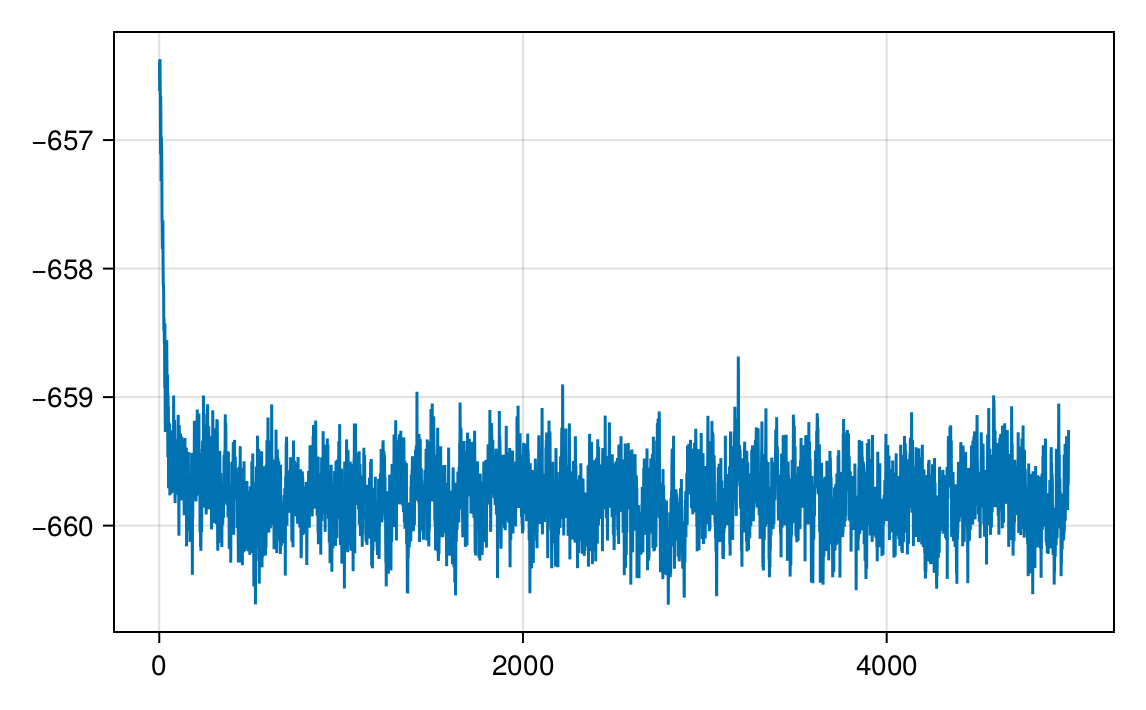

In [19]:
fig = Makie.Figure()
ax = Makie.Axis(fig[1,1], width=500, height=300)
Makie.lines!(ax, sampled_f)
Makie.resize_to_layout!(fig)
fig

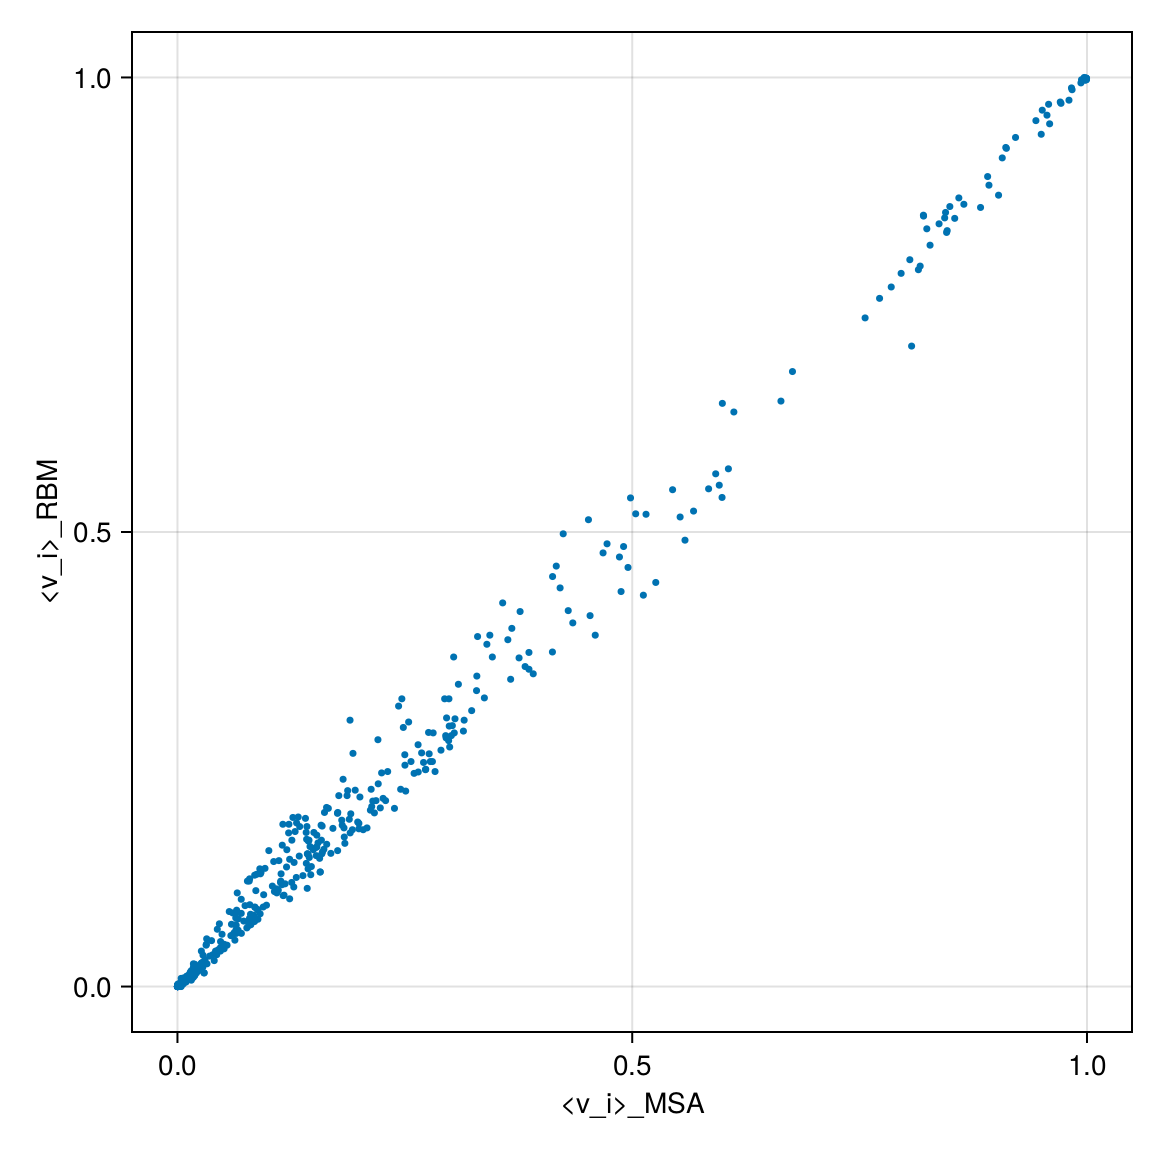

In [20]:
fig = Makie.Figure()
ax = Makie.Axis(fig[1,1], width=500, height=500, xlabel="<v_i>_MSA", ylabel="<v_i>_RBM")
Makie.scatter!(ax,
    vec(mean(cpu(data_hits); dims=3)),
    vec(mean(cpu(sampled_v); dims=3)),
    markersize=5
)
Makie.resize_to_layout!(fig)
fig

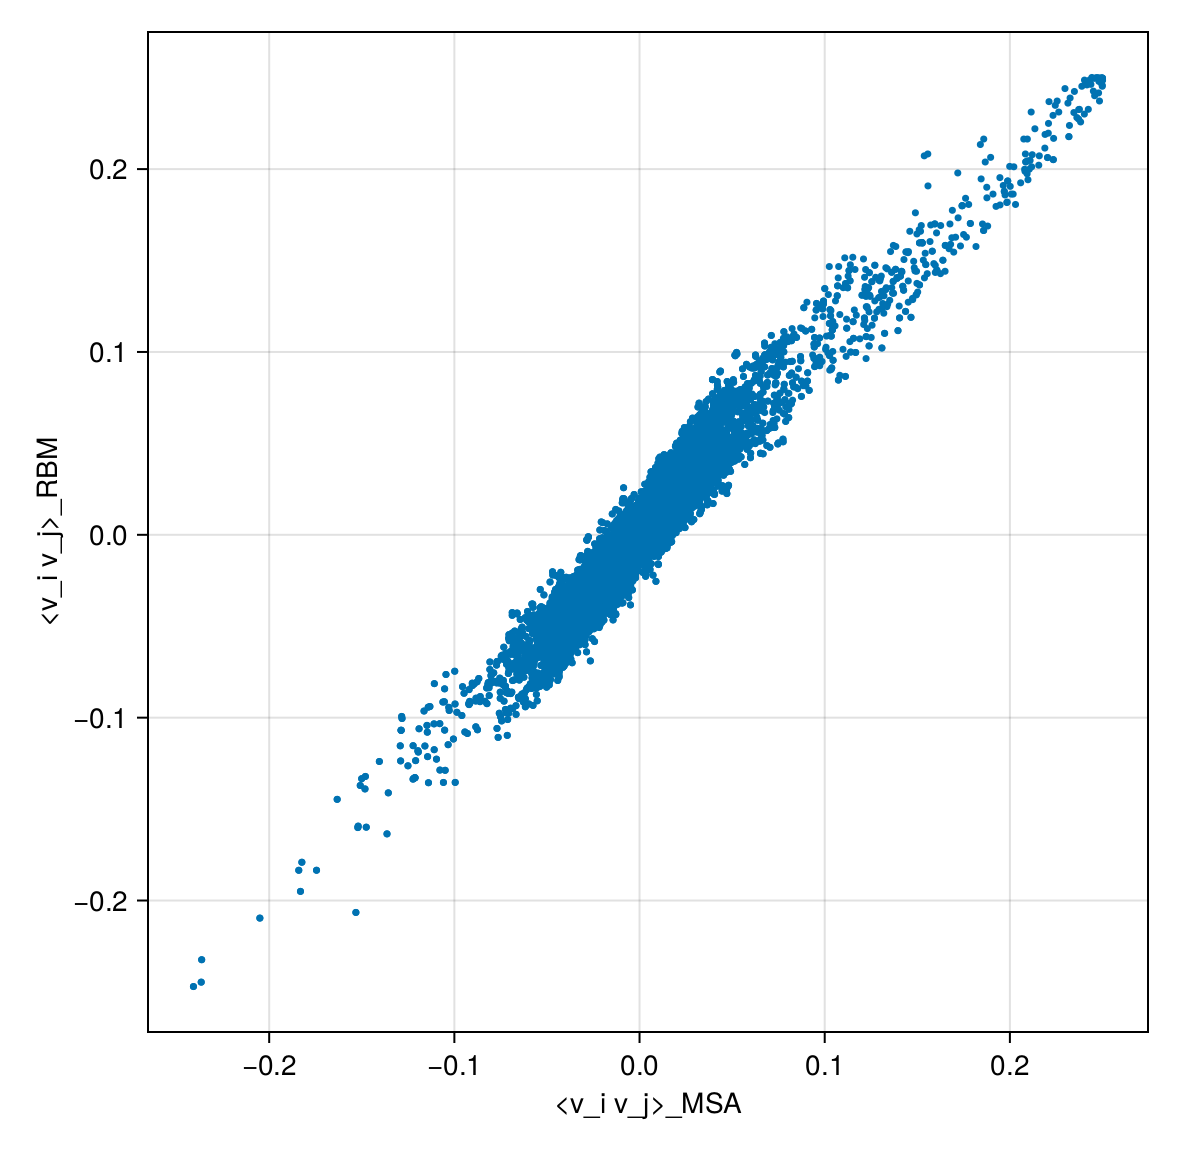

In [21]:
fig = Makie.Figure()
ax = Makie.Axis(fig[1,1], width=500, height=500, xlabel="<v_i v_j>_MSA", ylabel="<v_i v_j>_RBM")
Makie.scatter!(ax,
    vec(cov(reshape(cpu(data_hits), length(rbm.visible), :); dims=2)),
    vec(cov(reshape(cpu(sampled_v), length(rbm.visible), :); dims=2)),
    markersize=5
)
Makie.resize_to_layout!(fig)
fig

In [16]:
extrema(rbm.w)

(-0.92227465f0, 0.8926724f0)

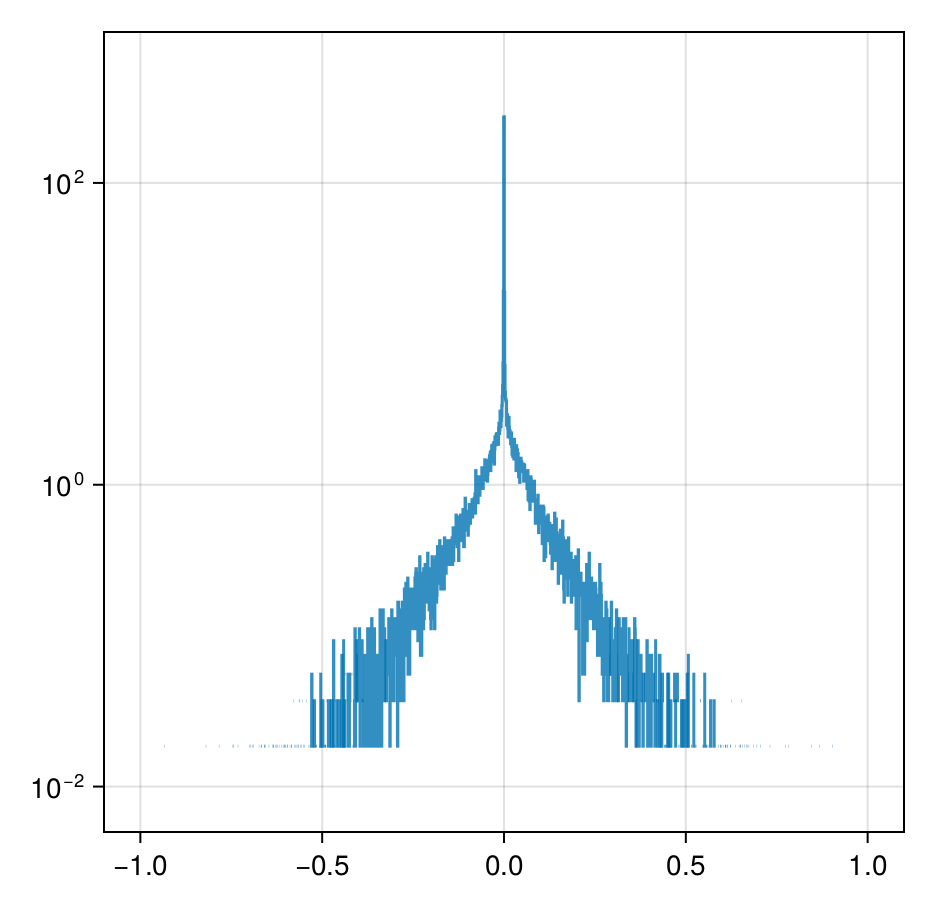

In [22]:
fig = Makie.Figure()
ax = Makie.Axis(fig[1,1], width=400, height=400, yscale=log10)
Makie.stephist!(ax, vec(cpu(rbm).w), bins=-1:0.001:1, fillto=1e-5, normalization=:pdf)
Makie.ylims!(ax, 5e-3, 1e3)
Makie.resize_to_layout!(fig)
fig

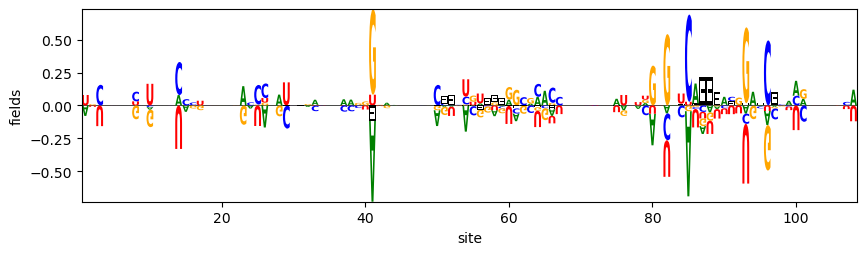

In [18]:
seqlogo_fields(rbm.w[:,:,1]).fig

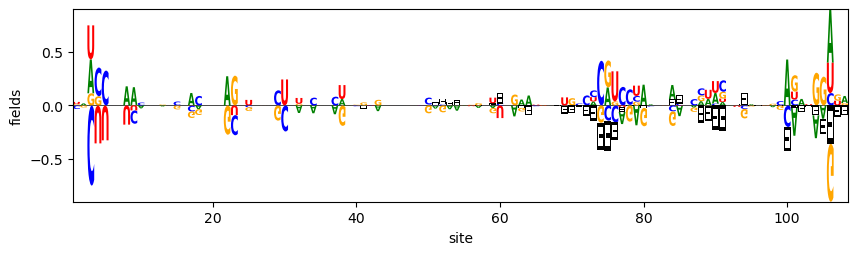

In [19]:
seqlogo_fields(rbm.w[:,:,2]).fig

In [20]:
[norm(rbm.w[:,:,μ]) for μ = 1:length(rbm.hidden)] |> extrema

(1.7100827f0, 2.4425259f0)